<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Finite Differences - Grid-Staggering Elastic 2D</div>
        </div>
    </div>
</div>

<p style="width:20%;float:right;padding-left:50px">
<img src=../../share/images/book.jpg>
<span style="font-size:smaller">
</span>
</p>


---

This notebook is a private extension writen by Yajian Gao based on part of the supplementary material 
to [Computational Seismology: A Practical Introduction](https://global.oup.com/academic/product/computational-seismology-9780198717416?cc=de&lang=en&#), 
Oxford University Press, 2016.


##### Authors:
* Ashim Rijal ([@ashimrijal](https://github.com/ashimrijal))
* Heiner Igel ([@heinerigel](https://github.com/heinerigel))
* Yajian Gao

This exercise covers the following aspects:

* Solving velocity-stress formulation of 2D wave equation with finite difference method
* Understanding the grid-staggering in connection with finite difference solution to the elastic wave equation
---

### Exercise
First understand the codes below and run the simulation. 

Then, improve the result using (4-point operator) for 1st derivative.

**Message: Once you become familiar with all the codes below you can go to the Cell tab on the toolbar and click Run All.**


In [1]:
# Configuration step (Please run it before the simulation code!)
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import jit
from matplotlib import cm


In [2]:
# Initialization of parameters

# Simple finite difference solver
# Elastic wave equation
# 2-D regular staggered grid

# Basic parameters
nt = 3000                                       # number of time steps
nx = 1000                                             # number of grid points in x
nz = 400
                                              # velocity (m/sec) (compression wave)
vp=np.zeros((nx,nz))+7000
vs=np.zeros((nx,nz))+5000
rho0=5000
irx=np.linspace(200,900,15)
irz=np.zeros(18)+(nz-3)

dx=1000                                          #m
dz=1000





isnap = 3                                              # snapshot frequency
isx = 200                                     # source location
isz = 200 


#####stable creterias
f0 =  np.max(vp)/dx/20
eps = 0.4
dt=eps*dx/np.max(vp)
dt_stable=dx/(7/6)/np.sqrt(2)/3000
print('f0=',f0)
print('dt=',dt)
print('dt_stable=',dt_stable)


nop = 10                                                # number of operator either 2 or 4


x = (np.arange(nx)*dx)                                 # initialize space coordinates 
z = (np.arange(nz)*dz)
                                     # calculate time step from stability criterion(s)



# Source time function
t = (np.arange(nt) * dt)                             # initialize time axis
T0 = 1. / f0                                           # period
a = 4. / T0                                            # half-width (so called sigma)
t0 = T0 / dt
tmp = np.zeros(nt)
for it in range(nt):
    t = (it - t0) * dt
    tmp[it] = -2 * a * t * np.exp(-(a * t) ** 2)       # derivative of Gaussian (so called sigma)
src = np.zeros(nt)                                     # source
src[0:len(tmp)] = tmp
lam = np.max(vp) * T0                                          # wavelength


#####source term in space
mxx=1e6/dx/dz
mzz=1e6/dx/dz






f0= 0.35
dt= 0.05714285714285714
dt_stable= 0.20203050891044214


In [3]:
np.shape(z)

(400,)

In [4]:
np.shape(vp)

(1000, 400)

In [5]:
#####here we could add some heterosgenities in the velocity model
for i in np.arange(150,350):
        vp[i][i:i+60]=1.1*vp[i][i:i+60]
        
        
vp[:,350:400]=7000
        
   

In [6]:
x_coord=np.tile(x,(nz,1))
z_coord=np.swapaxes(np.tile(z,(nx,1)),0,1)


In [13]:
x_coord=np.tile(x,(nz,1))
x_coord=np.reshape(x_coord,(1,nx*nz))


print(x_coord)
z_coord=np.swapaxes(np.tile(z,(nx,1)),0,1)
z_coord=np.reshape(z_coord,(1,nx*nz))
#print(z_coord)
xyz_matrix=np.zeros((2,nx*nz),dtype=float)
xyz_matrix[0]=x_coord
xyz_matrix[1]=z_coord


Vp=np.reshape(vp,(1,nx*nz))
Vs=np.reshape(vs,(1,nx*nz))
Velocity_matrix=np.zeros((2,nx*nz),dtype=float)
Velocity_matrix[0]=Vp
Velocity_matrix[1]=Vs

Vpv_smooth_all=np.zeros((2,nx*nz),dtype=float)



[[     0   1000   2000 ... 997000 998000 999000]]


In [15]:
import numba
############################################################################################################
@numba.jit(nopython=True)
def smooth_new(xyz_matrix,iterations,sigmaxy,sigmaz,Velocity_matrix,Vpv_smooth_all):
        '''
        you still need to input a empty matrix input if you want to use this
        '''       
        for i in range(iterations):
            ###L2 difference between point i and the the position vector in x with sigma
            distance=(np.square(xyz_matrix[0][i]-xyz_matrix[0]))/(2*sigmaxy*sigmaxy)+\
                     (np.square(xyz_matrix[1][i]-xyz_matrix[1]))/(2*sigmaxy*sigmaz)
            distance=np.exp(-distance)
            distance= distance/np.sum(distance)
            Vpv_smooth_all[0][i] = np.dot(distance, Velocity_matrix[0])
            Vpv_smooth_all[1][i] = np.dot(distance, Velocity_matrix[1])
        return Vpv_smooth_all
        


In [ ]:
Vpv_smooth_all=smooth_new(xyz_matrix,nx*nz,10000,10000,Velocity_matrix,Vpv_smooth_all)

In [14]:
vpv=Vpv_smooth_all[0].reshape(nx,nz)

<IPython.core.display.Javascript object>


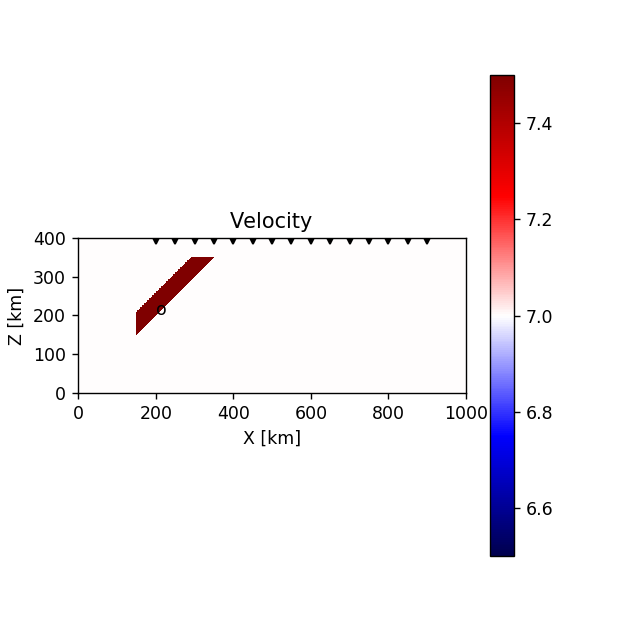

In [15]:
fig = plt.figure(figsize=(5,5))
image = plt.imshow(vpv.T/1000, animated=True, cmap=cm.seismic, interpolation='nearest', vmin=6500/1000, vmax=7500/1000)
plt.colorbar()
plt.title('Velocity')  
plt.xlabel('X [km]')
plt.ylabel('Z [km]')
plt.gca().invert_yaxis()
plt.text(isx, isz, 'o')
for i in range(len(irx)):
    plt.plot(irx[i], irz[i], 'vk')
plt.ion()
plt.show(block=False)

In [250]:
np.shape(vp)

(1000, 400)

In [251]:
dx/(7/6)/np.sqrt(2)/3000

0.20203050891044214

In [5]:
@jit(nopython=True,parallel=True) # use JIT for C-performance
def update_v(vx, vz, sxx, szz, sxz,szx, nx, nz, dt,dx,rho,ni1,ni2,nk1,nk2,lamd,mu):
    for i in range(ni1,ni2):
        for j in range(nk1, nk2):
            dsxx =  9/8*(sxx[i+1][j]-sxx[i][j])/(dx)-1/24*(sxx[i+2][j]-sxx[i-1][j])/(dx)
            dszx = 9/8*(szx[i][j]-szx[i-1][j])/(dz)-1/24*(szx[i+1][j]-szx[i-2][j])/(dx)
            dszz = 9/8*(szz[i][j+1]-szz[i][j])/(dz)-1/24*(szz[i][j+2]-szz[i][j-1])/(dx)
            dsxz = 9/8*(sxz[i][j]-sxz[i][j-1])/(dx)-1/24*(sxz[i][j+1]-sxz[i][j-2])/(dx)
            vx_new=(dsxx+dsxz)
            vz_new=(dszz+dszx)
            vx[i,j]=vx[i][j]+dt*(vx_new/rho[i,j]) 
            vz[i,j]=vz[i][j]+dt*(vz_new/rho[i,j])
    return vx,vz



<IPython.core.display.Javascript object>


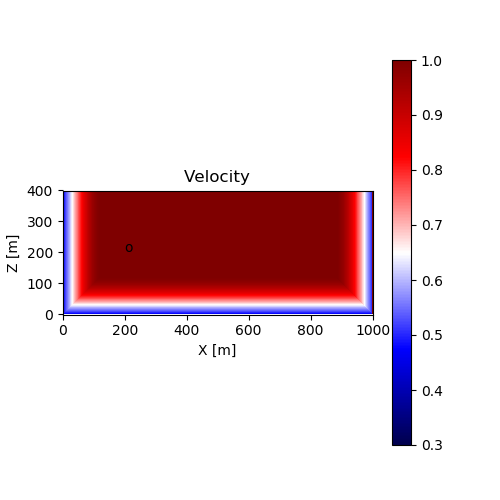

In [6]:

def generate_damp_guassian(nx,nz,ni1,ni2,nk1,nk2,absorb_thickness_n):
    #absorbpoint_x=np.arange(ni1,ni1+absorb_thickness_n-1)
    damp=np.ones((nx,nz))
    ####left boundary
    for i in range(ni1,ni2):
        for j in range(0,absorb_thickness_n):
            #print()
            damp[i,j]=(np.exp(-(0.007*(ni1+absorb_thickness_n-j))**2))
            
            
    #lower boundary
    for i in range(nk1,absorb_thickness_n):
        for j in range(0,nk2):
            #print()
            damp[i,j]=(np.exp(-(0.007*(nk1+absorb_thickness_n-i))**2))
            #print(j,damp[i,j])   
    # right boundary       
    for i in range(ni2-absorb_thickness_n,ni2):
        for j in range(0,nz):
            #print()
            damp[i,j]=(np.exp(-(0.007*(ni2-absorb_thickness_n-i))**2))
            #print(j,damp[i,j])    
    # left lower corner 
    for j in range(0,nk1+absorb_thickness_n):
        damp[j:ni1+absorb_thickness_n,j]=(np.exp(-(0.007*(nk1+absorb_thickness_n-j))**2))
                
    # right lower corner
    for j in range(0,nk1+absorb_thickness_n):
        damp[ni2-absorb_thickness_n:ni2-j,j]=(np.exp(-(0.007*(nk1+absorb_thickness_n-j))**2))   
    
            
    return damp


stencil=2
ni1=stencil+1
ni2=nx-stencil
nk1=stencil+1
nk2=nz-stencil
damp=generate_damp_guassian(nx,nz,ni1,ni2,nk1,nk2,120)
fig = plt.figure(figsize=(5,5))
image = plt.imshow(damp.T, animated=True, cmap=cm.seismic, interpolation='nearest', vmin=0.3, vmax=1)
plt.colorbar()
plt.title('Velocity')
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.gca().invert_yaxis()
plt.text(isx, isz, 'o')
plt.ion()
plt.show(block=False)    
    
    
    
    
    

In [225]:
damp

array([[0.47648406, 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.47648406, 0.48223873, 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.47648406, 0.48223873, 0.48801507, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.47648406, 0.49962923, 0.49962923, ..., 0.49962923, 0.49962923,
        0.49962923],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

In [7]:
@jit(nopython=True,parallel=True) # use JIT for C-performance
def update_s(vx, vz, sxx, szz, sxz,szx, nx, nz, dt,dx,rho,ni1,ni2,nk1,nk2,lamd,mu):
    for i in range (ni1, ni2):
        for j in range(nk1, nk2-1):
            ezx=9/8*(vz[i+1,j]-vz[i,j])/dx-1/24*(vz[i+2][j]-vz[i-1][j])/dx
            exz=9/8*(vx[i,j+1]-vx[i,j])/dz-1/24*(vx[i][j+2]-vx[i][j-1])/dz
            exx=9/8*(vx[i,j]-vx[i-1,j])/dx-1/24*(vx[i+1,j]-vx[i-2,j])/dx
            ezz=9/8*(vz[i,j]-vz[i,j-1])/dz-1/24*(vz[i,j+1]-vz[i,j-2])/dz
            #hTxx=(lamd[i,j]+2*mu[i,j])*exx+lamd[i,j]*ezz
            #hTzz=(lamd[i,j]+2*mu[i,j])*ezz+lamd[i,j]*exx
            #hTxz=(mu[i,j])*ezx+(mu[i,j])*exz
            sxx[i,j]=sxx[i,j]+((lamd[i,j]+2*mu[i,j])*exx+lamd[i,j]*ezz)*dt
            sxz[i,j]=sxz[i,j]+((mu[i,j])*ezx+(mu[i,j])*exz)*dt
            szz[i,j]=szz[i,j]+((lamd[i,j]+2*mu[i,j])*ezz+lamd[i,j]*exx)*dt
            szx[i,j]=szx[i,j]+((mu[i,j])*ezx+(mu[i,j])*exz)*dt
        ### free surface
        sxx[:,nk2]=sxx[:,nk2]+((lamd[:,nk2]+2*mu[:,nk2])*exx-(lamd[:,nk2]**2/(lamd[:,nk2]+2*mu[:,nk2])*exx))*dt
            #sxz[i,j]=sxz[i,j]+((mu[i,j])*ezx+(mu[i,j])*exz)*dt
        szz[:,nk2]=szz[:,nk2]
            #szx[i,j]=szx[i,j]+((mu[i,j])*ezx+(mu[i,j])*exz)*dt                
    return sxx,sxz,szz,szx

In [8]:

import datetime

######here you could input a heterogenity vp and vs

def assemble_psv(dx,dz,rho0,vp,vs,dt,nt,nx,nz,irx,irz,isx,isz,src,damp):
    t1 = datetime.datetime.now() 
    rho=np.zeros((nx,nz))+rho0
    mu = np.zeros((nx,nz))+rho*vs**2
    lamd=np.zeros((nx,nz))+rho*vp**2-2*mu
    ##### initial the cycle
    vx = np.zeros((nx, nz))
    vz = np.zeros((nx, nz))
    sxx = np.zeros((nx, nz)) 
    sxz = np.zeros((nx, nz))
    szz = np.zeros((nx, nz))
    szx=np.zeros((nx, nz))
    seis = np.zeros((len(irx), nt))
    print(np.shape(seis))
    ir = np.arange(len(irx))
    v = max([np.abs(src.min()), np.abs(src.max())])
    stencil=2
    ni1=stencil+1
    ni2=nx-stencil
    nk1=stencil+1
    nk2=nz-stencil
    fig = plt.figure(figsize=(6,6))
    #extent = [np.min(),np.max(X),np.min(X),np.max(Y)]
    image = plt.imshow(vz.T, animated=True, cmap=cm.seismic, interpolation='nearest', vmin=-1e-3, vmax=1e-3)
    #image = plt.imshow(vp.T/100000, animated=True, cmap=cm.seismic, interpolation='nearest', vmin=-0.001, vmax=0.001)
    plt.colorbar()
    plt.title('Wavefield vy')
    plt.xlabel('X [km]')
    plt.ylabel('Y [km]')
    plt.gca().invert_yaxis()
    plt.text(isx, isz, 'o')
    plt.ion()
    plt.show(block=False)
    #### free surface by image
    #plt.text(isx, isz, 'o')
    for i in range(len(irx)):
        plt.plot(irx[i], irz[i], 'vk')
    #fig.canvas.draw()
      
    for it in np.arange (nt):
        szz[:,nk2]=0
        #for n in range(0,stencil-1):
        #    szz[:,nk2+1+n]=-szz[:,nk2-1-n]
         #   sxz[:,nk2+n]=-sxz[:,nk2-n-1]
        vx, vz = update_v(vx, vz, sxx, szz, sxz,szx, nx, nz, dt,dx,rho,ni1,ni2,nk1,nk2,lamd,mu)
        vx=vx*damp
        vz=vz*damp
        vz[:,nk2  :nz]  = 0.0;
        vx[:,nk2+1:nz]  = 0.0;
        vz[isx,isz]=vz[isx,isz]+src[it] 
        vx[isx,isz]=vx[isx,isz]+src[it] 
        ###for the receivers
        for k in np.arange(len(irx)):
            print(vz[int(irx[k]),int(irz[k])])
            seis[k,it]=seis[k,it]+vz[int(irx[k]),int(irz[k])]
        sxx,sxz,szz,szx = update_s(vx, vz, sxx, szz, sxz,szx, nx, nz, dt,dx,rho,ni1,ni2,nk1,nk2,lamd,mu)
        #sxx=sxx*damp
        #sxz=sxz*damp
        #szz=szz*damp
        #szx=szx*damp
        if (it % isnap) == 0:
            #print(np.shape(vz))
            image.set_data(vz.T)
            plt.plot
            fig.canvas.draw()
    t2 = datetime.datetime.now()   
    print(t2-t1)
    return vx, vz,seis








(15, 3000)


<IPython.core.display.Javascript object>


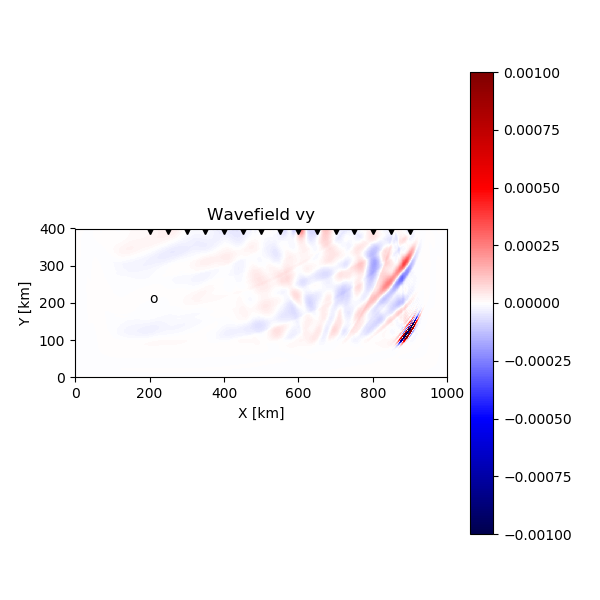

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


5.235467211999851e-149
5.188982156812848e-192
3.359693905060844e-279
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.034177039058363e-149
-4.557040090512587e-190
-6.049181603994172e-276
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.2400695454099409e-147
3.619988380502954e-188
8.776553856380663e-273
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0195638906310605e-146
-2.6070529647007958e-186
-1.042291047629115e-269
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.5689140936727032e-146
1.705660147953276e-184
1.0270107988747675e-266
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.2406408310187184e-145
-1.0155653408735657e-182
-8.495983713188604e-264
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.4567557212475415e-144
5.511404751219914e-181
5.962336400976287e-261
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.141650897568676e-145
-2.7297093145035247e-179
-3.5824262283806125e-258
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.4161876335190583e-143
1.23516123893818

-1.6945625116897626e-108
-1.1231003983428487e-126
-1.5275206666519171e-168
-5.7372832606126664e-226
-2.713563279093081e-303
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-7.082279996917856e-108
-1.1174688136225344e-126
1.3045277722712461e-167
2.146862861906255e-224
4.365359056280832e-301
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.8647743651511e-108
3.0348403296769175e-125
-3.706049197822894e-167
-7.57202598250468e-223
-6.547931083307969e-299
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.946635059102078e-107
1.9322689813271934e-125
-4.257429137773164e-166
2.5173015815527975e-221
9.171521366103051e-297
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.5044815888504364e-106
-7.782193238254297e-124
6.022032221595116e-165
-7.887388853785066e-220
-1.201277657984572e-294
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.9611404676548615e-106
-4.108394880558438e-124
-2.789858061093915e-164
2.3287054391590445e-218
1.4732842124632864e-292
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.3508553617568028e-105
1.9069611001917457

2.2185905889965348e-83
-1.018922147987042e-95
-1.117287930607246e-130
7.873420750516762e-174
-1.0540265610415234e-224
-1.546121647780246e-287
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.667248864655387e-83
1.9386667118297864e-95
-7.609786751715852e-129
-6.777513392473991e-173
-3.220753542584068e-224
5.732740766190409e-286
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.805479272636763e-82
1.6674901883763897e-94
9.936965582611346e-130
-2.84665406206176e-173
1.2673314534734273e-222
-2.030111034267127e-284
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.14128384136933e-83
1.6729434831036526e-94
1.7216285991242474e-127
2.857300806892714e-171
-1.5445140968084646e-221
6.866223092285036e-283
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.7304533317409141e-81
-1.5347042013339858e-93
3.737567847287081e-128
-1.0223391928824913e-170
1.1775471088004663e-220
-2.2178733564565777e-281
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.630573146196429e-81
-5.614698287054951e-93
-3.76332428186319e-126
-7.273840750629506e-170
-4.462720512576282e-2

-9.196866312590921e-65
-7.81058132497011e-74
-9.143404919603656e-102
-6.118871108925796e-141
-3.022539373672275e-186
-4.479602055300118e-237
4.0057826505783327e-292
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.4331680706624886e-65
3.486408489057694e-75
-3.869216667951124e-101
-5.462237558931596e-140
-5.5684229832363505e-186
7.168086959134051e-236
-5.867357646708387e-291
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.360188552748067e-64
5.827426399941227e-73
4.2976470271168516e-101
1.0685085405615497e-139
1.1775485764003409e-184
-3.545354918149727e-235
8.08753564997403e-290
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.6464218732391367e-63
1.6704901229945778e-72
5.943740632377914e-100
1.2146056756952242e-138
-9.980716087763568e-185
-1.017907969627663e-234
-1.0440090145284122e-288
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.256815770276644e-63
6.747563389998407e-73
6.653477375593484e-100
-1.5692409965785426e-138
-3.689673763519456e-183
2.701106027958501e-233
1.2537916670654873e-287
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.1052566420522056

-5.446805711991078e-50
5.707799505724831e-58
-8.089323433908623e-80
5.115452383253868e-115
-2.585929166791162e-156
-6.455806086540981e-203
-5.979646264930673e-254
-1.655451844395164e-308
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.4295019360904775e-49
9.699474294235896e-57
-1.4998273848790504e-79
5.2927512874693256e-114
-8.492021976341814e-156
2.4886772895462086e-202
-7.255614144220924e-253
-4.354830620905994e-307
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.2732577882876532e-49
2.669241982781453e-56
3.44164702398945e-79
2.6497502978522904e-114
4.923299406518947e-155
1.5664463279964066e-201
6.972900158359887e-252
6.88770699079991e-306
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.1388900208223603e-49
3.042924602449953e-56
2.2166000425975816e-78
-6.85343166866808e-113
2.0554228927322373e-154
-1.0186370964987869e-200
-5.995110558188131e-252
-5.73771530303147e-305
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.255058871870292e-49
-4.729806149262925e-56
2.6439545730895726e-78
-1.6626173717826487e-112
-8.747528617578102e-154
-3.148388724585232e-200

-3.8662702746039384e-38
-4.948231932116899e-44
1.3245467562723288e-62
-1.3341588948161584e-93
-2.363787628763544e-133
-1.4889668443880102e-175
5.63379396753015e-224
-8.726156215981606e-275
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-8.819743386697038e-38
2.984315994337049e-44
-1.1630167692572019e-62
1.1181387406034342e-93
-2.270514733448767e-131
4.5527925499758865e-175
2.9219324776350986e-222
4.012112283657723e-273
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.3422520101048265e-37
3.006625552219917e-43
-1.1951773897399662e-61
1.6294351121291283e-92
-3.567301318267074e-131
3.3653130619595843e-174
-5.561802536445425e-222
-1.4489861567391928e-272
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.83440175277935e-38
7.936760042142571e-43
-2.4915117174942475e-61
2.7596662861171736e-92
2.6977178853580983e-130
-7.318888566425671e-174
-7.795461777751255e-221
-1.0232790830987494e-271
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.783008266015611e-37
1.1672563032138219e-42
1.0160432056643833e-61
-9.787603315089218e-92
9.931007295149444e-130
-7.36573429847384e-1

1.1843635491170039e-29
-2.654489766570971e-33
-7.310669154940162e-49
1.8462667303315435e-76
-4.201843433978601e-112
4.092331003547377e-153
7.88224286966072e-198
3.340243920077863e-246
1.3175583537852547e-297
0.0
0.0
0.0
0.0
0.0
0.0
1.462842474989669e-28
-1.5231809093530925e-33
1.0517229902259608e-48
-2.8089949387531553e-76
1.0907215107440736e-111
2.890684835576011e-152
1.214758038081764e-197
-8.769719971083158e-246
-8.769261373324936e-297
0.0
0.0
0.0
0.0
0.0
0.0
3.9820794757734237e-28
4.7096962964028755e-33
6.670178075680711e-48
-2.1987478239291474e-75
7.190051341501814e-111
-1.7730888286277966e-152
-1.6067513222139037e-196
-8.596563464197998e-245
-1.7983679919674692e-296
0.0
0.0
0.0
0.0
0.0
0.0
7.355591879195614e-28
1.9291571141908584e-32
1.3074807258980996e-47
-3.4978877892802563e-75
3.91273741641213e-111
-4.747891194248604e-151
-3.4410484088153886e-196
3.4820259589086045e-244
4.128270520814721e-295
0.0
0.0
0.0
0.0
0.0
0.0
9.718161872620425e-28
4.111424099754134e-32
2.312125250568205

2.8387965966612135e-21
3.399895672658491e-24
-7.954586219684092e-37
3.634829275770043e-61
-7.452968464608507e-94
-1.82818780303652e-132
-5.13616879894495e-176
7.538937301705898e-222
-1.1997101966027759e-270
-1.047e-321
0.0
0.0
0.0
0.0
0.0
1.7016493044313853e-20
2.8594537515884266e-24
1.5541712511778581e-37
-6.965708488130583e-61
-1.8017549671417455e-93
-8.146920791031045e-132
-2.296070863376872e-174
-2.2616366472673407e-220
-2.5390722548008666e-269
-1.877e-321
0.0
0.0
0.0
0.0
0.0
4.054720011556927e-20
-1.5957065448901743e-24
3.651788195006468e-36
-4.176578689274326e-60
2.1884817341877057e-93
4.928433331183731e-132
-2.586417998265533e-174
-2.7129065725682754e-220
6.084629308358239e-269
4.5256e-320
0.0
0.0
0.0
0.0
0.0
7.059465902359004e-20
-1.271576666367118e-23
9.436245323236905e-36
-6.823405975371495e-60
2.1566824455075185e-92
1.0894655556339553e-130
3.298419815290671e-173
4.663326185334931e-219
6.536666831647015e-268
-8.258e-320
0.0
0.0
0.0
0.0
0.0
9.552251996189733e-20
-3.16831250165

5.62957679691934e-15
2.6066950798853257e-17
-1.0626255152622407e-27
-4.055785696927884e-49
5.539557412450464e-80
1.1489091828273883e-115
-2.6944031721171204e-156
6.013518456589227e-200
-1.999995973837004e-247
-6.483135561248472e-297
0.0
0.0
0.0
0.0
0.0
-3.536956618597431e-15
5.2668927152728216e-17
1.3367710371000203e-27
-5.196669010232749e-48
-2.2972905419371144e-78
1.3857708136453127e-114
-3.440692995280173e-155
1.9760923079514787e-199
2.7290317612856806e-246
6.771694638668076e-296
0.0
0.0
0.0
0.0
0.0
-2.0801603549368085e-14
8.096712054915126e-17
7.127342736477658e-27
-1.1911690960584183e-47
-6.435689887151313e-78
2.178830226731002e-114
-3.3457895022270457e-155
-7.535837983615258e-199
5.431661294211011e-246
1.1214569118615816e-295
0.0
0.0
0.0
0.0
0.0
-4.674369661550422e-14
9.521019718895679e-17
1.5004863585447387e-26
-5.225479110339693e-48
6.897450309829888e-80
-8.505645191260628e-114
3.8023567679949234e-154
-4.3706083132904815e-198
-5.736649568061175e-245
-2.0340232080128974e-294
0.0

-2.5209628489797187e-09
-1.7100265246285835e-12
2.726665427472753e-20
3.822922673222918e-37
-2.2047164229476286e-65
1.377659073585783e-99
4.143897799483989e-138
2.6882141605989723e-180
-1.4938408681394968e-225
1.6243559999603201e-273
0.0
0.0
0.0
0.0
0.0
-5.0838700937345165e-09
-6.889613776692648e-12
-1.3078972977277663e-19
4.059663166632156e-37
8.441713737702055e-65
9.647449373548676e-99
1.7341656247394982e-137
-1.2519398690044942e-180
-2.5953523451091145e-225
-6.26441316066921e-273
-3e-323
0.0
0.0
0.0
0.0
-8.767830169196097e-09
-1.4075719633543407e-11
-4.1799352815031363e-19
-5.526763324515471e-37
3.629454528171095e-64
1.3190045291776843e-98
-4.945723028743216e-138
-3.968103268544274e-179
2.317534929711029e-224
-3.834828372061809e-272
-3.75e-322
0.0
0.0
0.0
0.0
-1.3551046704345557e-08
-2.218781942563537e-11
-7.591556284270657e-19
-3.202848194139902e-36
4.4982282254319537e-64
-4.627054814000172e-98
-1.9843316592567106e-136
-5.800847330451924e-179
7.483650794745943e-224
1.27377821615380

-0.0002678509134975247
1.238711454029328e-06
1.2079482800800829e-13
3.419098401127892e-28
-3.6547829210256304e-53
1.0574108999802241e-85
-5.04390694291755e-123
-3.039977128028443e-163
-1.5470963571040335e-207
-4.4061380012699085e-253
1.0680618818426353e-301
0.0
0.0
0.0
0.0
-0.0003425398989511612
1.6563448200981689e-06
1.2160578557744199e-13
-2.466232293018807e-28
-4.650309786902149e-53
-2.7066207526786015e-85
4.754006695421557e-122
-1.3137637639408523e-162
-3.3754169240269957e-206
-5.524297722071313e-253
6.309270107860648e-302
0.0
0.0
0.0
0.0
-0.00042762057743848616
2.0462371943353543e-06
5.41641832829903e-14
-1.849956144135197e-27
6.842396456703023e-53
-1.4696076218349999e-84
1.6473338560837572e-121
6.709853089977567e-163
-3.65627509127552e-206
7.531329153041042e-252
-2.4638094862725085e-300
0.0
0.0
0.0
0.0
-0.0005216266605744684
2.2802845868086236e-06
-1.1365472728684356e-13
-3.9625165544170374e-27
4.28414932260682e-52
-1.962043654863655e-84
-2.6809060648377984e-122
1.680555644256983

0.0010864960984554
-0.0005788256600069056
-2.8131758371030854e-09
6.759164622855664e-20
1.4922323956484217e-42
-2.3374550760235465e-72
-1.5561612205215837e-107
-1.569877903669954e-146
1.0811081866410032e-188
-1.6107066520543912e-233
-9.537371147499604e-281
0.0
0.0
0.0
0.0
0.0009117151286207046
-0.0003195558301901886
-5.656233457255317e-09
6.108394825662324e-20
-4.205371091153308e-42
-7.020769366446458e-72
-4.20133245824135e-107
-4.4485275243904075e-147
3.105221461661596e-188
3.865121397556435e-233
5.539109939990058e-280
0.0
0.0
0.0
0.0
0.0007333119051044555
-3.435162044864549e-05
-9.600733512363101e-09
-3.648295776221464e-20
-1.7881454276471456e-41
-4.510327714921116e-72
1.4135728462396867e-107
1.4627706375598169e-145
-6.918183929184021e-188
3.1269599671951354e-232
2.375326305936321e-279
0.0
0.0
0.0
0.0
0.0005589766917410523
0.0002653748283431096
-1.4408626670003867e-08
-2.619980564339654e-19
-2.8855062869689975e-41
3.0706036016601534e-71
3.6825330098368975e-106
3.983755682923141e-145


-7.597276691735918e-05
-0.00030021153225066795
-0.0003801875015315417
-1.7094030400792385e-14
-3.202170358254507e-33
7.052746160258248e-61
-2.1271086811404502e-94
5.956268282456137e-132
6.125510935311623e-173
4.541719524738549e-216
-7.788949269227845e-262
-4.6541080974805e-310
0.0
0.0
0.0
-6.95585359543227e-05
-0.00029612921939759163
-0.00047336542704845677
-7.6434599677781e-14
-1.467212810509393e-32
5.6869768084749035e-61
-2.502854318584495e-94
2.094106813026202e-132
3.95186841213949e-172
1.0530194411958539e-215
-2.0780614816314372e-261
-5.067243692223397e-309
0.0
0.0
0.0
-6.385866516750823e-05
-0.0002862267980632477
-0.0005750379227696372
-1.441556108061253e-13
-2.617546308444299e-32
-2.2291160078296022e-60
8.066725968265998e-94
-4.65809394808684e-131
2.613920317914928e-172
-3.9088278621368814e-215
9.452137338987333e-261
4.831949192826805e-309
0.0
0.0
0.0
-5.878969347375567e-05
-0.0002722726582984261
-0.0006819195087004871
-1.7839826814743148e-13
-1.2833147079753807e-32
-9.0134379741

-1.3590455906665273e-05
-3.3112878755707446e-05
0.0012843501432371943
1.519044241663308e-10
6.482508548562444e-25
-4.425778661128771e-51
3.476029157530298e-83
7.57627534686807e-119
-1.2834999943473422e-158
6.232349979780044e-201
-6.647591797751008e-245
2.615494346309681e-291
0.0
0.0
0.0
-1.3048042925157641e-05
-3.1246119938428294e-05
0.0011461632025091062
2.607478600416768e-10
5.353485096469567e-25
-2.199528368593044e-50
-2.3834563137150853e-82
-1.1889890342322678e-118
-1.493740718797406e-157
1.2379576545883832e-199
2.8093739902808973e-244
5.205585929250522e-291
0.0
0.0
0.0
-1.2535933345327699e-05
-2.9531394518150054e-05
0.0009926473797482985
3.538094040315226e-10
-7.17964707414911e-25
-3.8246018034048493e-50
-8.54420699237753e-82
-8.952691065615978e-118
-2.4926286438987796e-157
2.0594803498774517e-199
1.4679384814556604e-243
-3.7261021735784157e-290
0.0
0.0
0.0
-1.2051956679445692e-05
-2.7952221260915744e-05
0.000831408556275052
4.260005193009683e-10
-3.529678813968077e-24
-2.74935647

-5.306978151185212e-06
-9.661029795326687e-06
-0.0001121789602919813
-1.683587465365676e-06
-2.121882273778569e-18
4.853989353673602e-43
-6.402974882309578e-72
7.864922684699901e-107
-6.170844514291743e-145
6.218011655332793e-186
-4.7643072205881164e-229
1.8398310177896872e-274
2.7e-322
0.0
0.0
-5.161834414012505e-06
-9.33790446698249e-06
-0.00010207059531652722
-5.562131067040637e-06
-4.085051103817356e-18
-1.5314666409569085e-41
-4.674765988767248e-72
3.7014466795729383e-106
-3.185907822407565e-144
-2.699481210295462e-185
-1.7321063569056937e-228
-1.066405848349499e-274
-2.71e-321
0.0
0.0
-5.022227748670938e-06
-9.029769236242667e-06
-9.296494420456249e-05
-1.2058802521870866e-05
-4.366931197891494e-18
-4.252960973594109e-41
2.2133657642866135e-71
4.529213004245778e-106
-3.0249070389768164e-144
-1.2896108048502615e-184
2.1766624259286536e-228
-2.9294651704831635e-273
-8.987e-321
0.0
0.0
-4.887883188151778e-06
-8.735746562804571e-06
-8.479958730044477e-05
-2.2168365722524193e-05
5.071

-2.76904464371036e-06
-4.403218533954133e-06
-1.7964501576136862e-05
8.613515029911862e-05
-1.745237680655359e-13
4.125783308907332e-34
-2.6524117166398625e-62
4.187090982516983e-96
1.8029671926325934e-132
1.4114119612660095e-172
-3.779125633618697e-215
-1.8569174300253365e-259
1.34884412959803e-305
0.0
0.0
-2.713685950405345e-06
-4.295174960802768e-06
-1.7169192545121023e-05
0.00028526829444686
-3.8221219804694913e-13
1.5496649418518396e-33
-1.8697201879932576e-62
-2.2400666784057485e-95
1.6172270924627093e-132
-5.4810098286256e-172
4.6246206096162275e-214
1.9346512019860387e-258
-8.118255068313877e-305
0.0
0.0
-2.6598364291109772e-06
-4.190822474671368e-06
-1.6424004789902213e-05
0.0004786967137391454
-5.130461370366586e-13
2.558563095135233e-33
7.829408728922675e-62
-8.648197525418324e-95
-9.387673313588982e-132
-2.68451983898264e-171
1.495979206654321e-213
6.407201857407011e-258
-3.4596733688041253e-304
0.0
0.0
-2.60739939691993e-06
-4.0899921808755795e-06
-1.5724794955179257e-05
0

-2.6726649159210163e-06
-2.4232409319896643e-06
-6.695200917371545e-06
-0.0001803242948971397
1.0948399697130536e-10
2.0542165338979167e-27
-2.001544362433098e-53
-2.6240609249760975e-85
-7.167470617336292e-121
1.5918391097641114e-159
5.150746102729923e-201
2.929161249138449e-244
1.6120421396221834e-289
0.0
0.0
-2.7296237957875425e-06
-2.376416426405533e-06
-6.499947871056963e-06
-0.00018756763998977382
1.3961976182400883e-10
-1.0180669812070084e-26
-5.39094123059429e-53
-7.732648823830018e-85
-5.794195920936773e-121
2.396506104587892e-159
3.246751881351225e-200
-6.760168774374883e-244
5.14951212922346e-289
0.0
0.0
-2.785758216450818e-06
-2.33091081229881e-06
-6.312697561348925e-06
-0.0001893625291384147
1.3643133755025205e-10
-3.2270270325626695e-26
-5.786081970363603e-53
-6.494544103078829e-85
3.343739497762963e-120
-6.92396030684571e-159
2.902562422021636e-200
-4.976579731318495e-243
-1.2592814715601088e-288
0.0
0.0
-2.8408985034087675e-06
-2.286672223840651e-06
-6.133037684243432e-

5.583993569509487e-06
-2.6883588204167822e-06
-3.354156322248973e-06
-3.0043198337417935e-05
1.840785164517511e-06
-1.3171048810204414e-20
5.105339363939219e-45
-1.7390569260397035e-75
5.587884652270375e-110
-1.466879379095974e-147
1.7975539350200092e-188
-4.087204868338589e-230
-2.60517219185336e-274
1.826e-320
0.0
7.783597100727921e-06
-3.166600701512771e-06
-3.281042328953718e-06
-2.818076217700315e-05
1.625203049170961e-06
-2.8447074015484093e-20
4.734101157267273e-45
-4.2641072809081284e-75
1.8459565200300396e-109
1.826660099738594e-147
4.443657959232877e-187
-2.0427085939516527e-229
-6.346905134249805e-274
-4.64e-322
0.0
1.0289696809801556e-05
-3.7357497973355904e-06
-3.2101922089200005e-06
-2.6487266890615696e-05
6.699779051254364e-07
-3.54329727446591e-20
-7.182085306752795e-45
-2.90880028424994e-75
1.5717273514599062e-109
1.5897432595475034e-146
9.810648472016672e-187
-5.631709788341922e-230
1.8955325045375888e-273
-2.7214e-319
0.0
1.3093513823559511e-05
-4.374130210570401e-06

-4.04017782269006e-08
0.0004374692697506526
-1.9704232705229113e-06
-8.503373948549189e-06
-0.0002127104651372053
-6.578235165410033e-16
-2.257691249573498e-37
-3.855976148172764e-67
1.9592681438394017e-99
6.057293660636261e-136
-6.068110191826727e-175
-2.0518179793213492e-216
1.0798385142098222e-260
-3.1373322834642374e-305
0.0
-5.439615526577361e-06
0.0004643191875845577
-1.9361584029199844e-06
-8.21193003269148e-06
-8.275808816414558e-05
-2.921846119916329e-15
-2.695018767797303e-37
-5.603960644039988e-66
1.120009013337523e-99
-2.9103674671258536e-136
-4.9449395859526204e-175
-6.716874031203153e-216
3.20584768033487e-259
1.3831202366420095e-304
0.0
-1.0298093114244792e-05
0.0004816248939436424
-1.9027552835140032e-06
-7.934837290053846e-06
5.4405179328934614e-05
-5.445943452157438e-15
7.010648399386296e-38
-1.3501455095615255e-65
-7.966768330854456e-99
-4.924828267395466e-135
3.627743533076325e-174
2.8043975336305328e-216
6.250183457691512e-259
7.013682681001176e-304
0.0
-1.44898904

-6.551563766085995e-06
-0.0004599007905977662
-1.275968525961993e-06
-4.069256872488128e-06
-2.7572979264451937e-05
-3.6340330487666856e-12
-5.919440540746534e-31
-1.0608783323821404e-58
8.478785663329774e-91
9.67521031404416e-126
2.613243947581386e-164
2.5782594981404655e-204
-8.279489663881383e-247
-1.4047022486504527e-291
0.0
-6.190812436953406e-06
-0.0003619437382136083
-1.2400819300725986e-06
-3.9698049632409995e-06
-5.997933869593883e-05
9.657295857463916e-13
-5.122075646701504e-31
2.804596618487358e-58
6.734020490562355e-90
-4.580130710692328e-126
2.4329354666778208e-163
7.195359686475983e-204
-4.303662081816923e-247
9.192908851686089e-291
0.0
-5.783343651215925e-06
-0.0002615935557442168
-1.203201715886132e-06
-3.873943264708312e-06
-8.523045084784894e-05
7.866302679819442e-12
4.95900545383234e-31
1.1986019273527045e-57
1.4173861278949851e-89
-7.324166427968604e-125
4.620972859113786e-163
-3.964258166219783e-204
7.487506636606881e-246
3.754659827374087e-290
0.0
-5.3196143608671

1.572905823561191e-05
4.407575005031405e-05
2.5233253038806112e-05
-2.3660016830721297e-06
-3.654956298127006e-05
1.8570227607375508e-09
-3.542809742102587e-25
8.897377224220126e-51
-1.2572300376859524e-81
7.452568074969776e-116
4.204863381190961e-153
-3.3968151698066233e-193
1.318242123485902e-234
-6.516768841276847e-278
0.0
1.6497646019706986e-05
4.244809413431708e-05
3.99243495041792e-05
-2.321775032700664e-06
-3.380942702470002e-05
4.546967385120262e-10
-6.711628375458815e-25
1.4491012092090658e-50
-3.5432434719659735e-81
1.1478296643981597e-115
1.0498752271389778e-152
-3.3049239321009083e-192
-4.053769034062874e-234
-7.157174958798992e-279
3.5e-323
1.7134147260567332e-05
3.9001718207729307e-05
5.872619745761599e-05
-2.2788047371137466e-06
-3.134121085536011e-05
-2.847833500690099e-09
-7.376075519805146e-25
5.49503168724939e-51
-3.79846108343177e-81
-1.121534083363377e-115
-1.2386555430390775e-154
-6.079665222622549e-192
-2.2834228388982573e-233
7.005767723132737e-277
4.3e-322
1.76

1.4405804164315216e-05
2.8184167931505794e-06
-0.00027084068987279816
-1.5515660009974245e-06
-8.953848159771764e-06
-3.588211151191492e-05
4.9817304390415935e-20
7.249009507903837e-44
1.7321533355654172e-73
-2.0433309105727087e-107
7.8714380978565645e-143
-1.6459245328594873e-181
-1.5394805704642032e-222
-6.387583884484137e-266
-1.261938403639143e-309
1.4000880114046338e-05
3.538754517507496e-06
-0.0003854571583586874
-1.5285061776667159e-06
-8.602443079743195e-06
-5.3980419714404604e-05
3.7999514229525046e-20
3.420603217746391e-44
6.291655430168861e-73
2.6020088086831175e-106
1.94264334987807e-142
-1.260860851884181e-181
2.918919214832278e-222
-1.3771689080052385e-264
-2.453926450840255e-309
1.3577494361917482e-05
4.474569207463131e-06
-0.0004894194942503496
-1.5059313738980756e-06
-8.271167997796775e-06
-7.696384358716509e-05
-2.4810622651821585e-20
-1.578491658908763e-43
9.761232950891423e-73
8.339268045827376e-106
3.8796163888158773e-143
8.864670152949782e-181
2.110934692456101e-2

3.2316280873823444e-07
1.8318001111336625e-06
0.00011739038969004432
-1.1168322687672185e-06
-4.045806492576577e-06
0.00030011044441001706
-7.762999219387454e-16
1.4236712689438787e-37
9.6347420871213e-66
1.7661764010105284e-98
-1.6128811852056323e-133
-3.4455645097990964e-171
1.2485455626445456e-211
-1.5963565295647728e-253
4.717383445641462e-297
-3.586388347276029e-07
1.5083451831974785e-06
0.00010968824428163654
-1.103005156715306e-06
-3.9373201715696195e-06
0.00037654900625508033
-1.2826621456215461e-15
2.457868122665163e-37
9.686095657684153e-66
-6.82306424695279e-98
1.769219132511486e-133
-5.245795314739886e-171
8.762141880398782e-211
6.092682255305762e-253
-2.5453674286289375e-297
-1.034623340126368e-06
1.3742787186552624e-06
0.00010104284477248733
-1.0894689559689657e-06
-3.833194426306822e-06
0.00044099930145894404
-1.4759528271486586e-15
2.0339458007109533e-37
-1.2402298685185556e-65
-2.7821599016643993e-97
1.4478779503746046e-132
9.405717316332987e-171
1.3541653098000692e-21

-1.2754855651531001e-05
7.442442995661439e-06
1.534996931252049e-05
-8.034278065284204e-07
-2.303563307543196e-06
-7.202079575791151e-05
-1.7596624088101674e-12
-5.082615549536982e-32
1.0392567223797798e-58
-8.035053449643747e-90
1.0157602265966697e-125
-1.3271189384824067e-161
1.126693526937158e-200
9.403329923988945e-242
-7.883236132418977e-285
-1.3077009953301714e-05
7.578343527704565e-06
1.4354167824537623e-05
-7.833721966794964e-07
-2.2579472633787017e-06
-7.970318702488381e-05
-1.9910541714187374e-12
1.125741254121877e-32
3.308088980897985e-59
-6.9768975155142915e-90
-5.874317948572549e-124
-7.437870742239958e-161
4.3034039193066634e-200
2.1451476260149216e-241
1.4482317592416812e-285
-1.3376437351366448e-05
7.692216382388746e-06
1.3169591862436579e-05
-7.669049823830248e-07
-2.2137673450320055e-06
-8.44252595829964e-05
-1.5866265196336128e-12
1.756040264538168e-31
-2.999345615430748e-58
1.7550325726878332e-89
-1.7102939856124587e-123
-1.2236811828357747e-160
3.357306526498216e-2

-1.4513967490332787e-05
7.2723143753803576e-06
4.169296150023457e-06
3.799966356422817e-05
-1.5106954258572982e-06
-2.2548585980488835e-05
1.0329700256165442e-09
5.21570338014922e-27
6.835069277671246e-52
1.1158455636781243e-82
-1.9311828863223803e-116
1.0453731928486487e-151
1.398614404183792e-190
1.0078926131594762e-230
5.368383284743866e-273
-1.4349367892030427e-05
7.106880378946556e-06
4.150558416203218e-06
5.237319901674153e-05
-1.4878268962007194e-06
-2.0990504570421e-05
1.7098979380614085e-09
-9.276580859135812e-27
7.066912821836408e-52
9.785851256966893e-82
2.7853088956677347e-115
8.721868940051959e-152
9.453614806643891e-190
-4.456707527666554e-231
1.2861090968723498e-272
-1.4169798152098102e-05
6.929722079096224e-06
4.058782790013757e-06
6.935205014406634e-05
-1.4655697508360276e-06
-1.9577378618380096e-05
2.462274315923957e-09
-3.759375336086336e-26
-4.561017756763881e-52
2.260661051818813e-81
8.876233941709664e-115
-3.8504762460581716e-151
1.65691821598065e-189
-9.360675141

-8.3178611205166e-06
3.3134398379097167e-06
2.174527924360664e-06
-0.0002540810884804499
-1.0920695622037216e-06
-6.279594481815812e-06
2.4661545103270705e-06
-8.923986146157794e-22
9.06416186782566e-46
1.257814307053763e-74
3.3324480629343553e-107
-1.039608358677888e-142
-2.258959635462611e-180
4.308130287426438e-220
6.140722684711074e-262
-8.13669054775106e-06
3.0698149691748414e-06
2.1848840136852225e-06
-0.0002869623736153006
-1.079206005337363e-06
-6.039323041759289e-06
1.5675716212181579e-06
-6.715307005814922e-22
2.760153954949148e-45
3.1320966546787985e-74
3.352052871543586e-108
1.3466777193876505e-142
2.7184172258689733e-180
-6.1715272595644394e-220
-3.011286017057063e-261
-7.983403946207446e-06
2.823017484763365e-06
2.1675390043894793e-06
-0.00030938823526120116
-1.0666130752209494e-06
-5.812534171791051e-06
-4.003999235140667e-07
4.0332804240203355e-22
4.5524924993308153e-45
3.6976850263011295e-74
-1.51267264431192e-106
9.718958472437008e-142
2.2505418927248124e-179
-4.96495

-2.1649015699257285e-06
-2.857301663745476e-07
1.5295088367562696e-06
4.7799258827840285e-05
-8.464367042837791e-07
-2.891116620975385e-06
-0.00014274810967309
4.348700319659744e-18
-1.4415815487924928e-39
1.6309422698250788e-67
-3.277989428692763e-99
8.211597662472946e-134
-1.0178065025016069e-170
1.48249961297336e-209
-7.946745291898416e-251
-1.6696406174442429e-06
-3.39354939028944e-07
1.5704738821735788e-06
4.5847640356417194e-05
-8.38496196810248e-07
-2.81527660628534e-06
-8.585068472633114e-05
1.766720254876853e-17
-1.7037983021511006e-39
4.00780610645145e-67
-1.0333100603337644e-98
-8.832403275838499e-134
-4.01680111440803e-170
6.308623350256522e-210
-5.438601627665664e-250
-1.2134441538381208e-06
-3.8889330128489947e-07
1.6109526523689977e-06
4.339500742812497e-05
-8.307131169705974e-07
-2.7424232667148913e-06
-2.409664936433862e-05
3.439430060807587e-17
-2.439571512181794e-40
5.034872103032131e-67
-1.4545595482084839e-98
-6.898396717509046e-133
-5.19518890139714e-170
-8.713135

1.8144841824243669e-06
-3.5200841222678413e-06
5.250802652772035e-06
6.513970490336926e-06
-6.89503410129605e-07
-1.6672280501614409e-06
4.5079001157124926e-05
1.4025830867600657e-14
5.027600424603266e-34
2.054133615538849e-61
-2.6464417897036057e-91
-5.081944191117778e-125
3.429336069291296e-161
1.3508128705931786e-199
-5.475448361167141e-240
1.8730914266389724e-06
-3.6465346490389944e-06
5.3941373241853935e-06
6.147332122799769e-06
-6.841922531874626e-07
-1.6350400135831663e-06
2.20463141362383e-05
5.0326305966862277e-14
4.3646180276197264e-34
1.8737286981098485e-60
-3.2660110625505874e-91
-5.050406182809554e-125
6.322297929761233e-161
4.564835482103337e-199
-2.897373000111896e-239
1.928569138347205e-06
-3.7562303600447802e-06
5.526107260341453e-06
5.813995412237244e-06
-6.789713714476302e-07
-1.6038602116491351e-06
2.3151021520351293e-06
9.372467800837588e-14
-2.4188568696018253e-34
4.4904009741802084e-60
2.000683123710256e-91
1.0945655283696676e-124
-1.6927016790989198e-161
4.04144

2.739143925400262e-06
-4.530983020774953e-06
6.269205474878331e-06
2.364408578688075e-06
-5.895522296897465e-07
-1.1088695682808592e-06
-2.6412120362228123e-05
-2.393801268719115e-11
-8.294372806061112e-29
-3.524916752030293e-54
-6.6786254639617825e-84
4.4361871091661314e-117
-3.67600672413218e-152
-8.292095088157807e-190
4.2742963636089757e-231
2.789425650081423e-06
-4.52451348279714e-06
6.212155891039262e-06
2.3058989452645277e-06
-5.851391401993144e-07
-1.092876983716911e-06
-2.446220247975837e-05
-4.4841401402209605e-11
-1.1913345141986387e-28
-3.730325041880161e-54
-5.45954206914826e-84
2.0647187868744695e-116
-6.577080270282164e-152
-6.604820065158986e-191
-6.1031045921993116e-229
2.8429324760901404e-06
-4.509461518178051e-06
6.155453807097522e-06
2.2469091014174766e-06
-5.785873549737915e-07
-1.0772963655827452e-06
-2.2667891508203887e-05
-7.344995282209814e-11
-9.901224417490687e-29
1.415970738555332e-54
1.13847455080954e-83
3.859754863747113e-116
1.0720594803515221e-152
5.0098

4.426789358549892e-06
-3.7338229777182987e-06
4.404795900863857e-06
2.7177935974506702e-06
-9.023606247456765e-06
-8.18374011419334e-07
-6.035662974726916e-06
-9.391017834565135e-08
5.470237164941639e-26
1.6423360004839128e-48
-1.0015970876987648e-76
9.372345432478216e-109
1.4128416084065507e-143
8.375351043498491e-181
3.278824049811166e-219
4.481555819538391e-06
-3.674627953803357e-06
4.272682442177195e-06
2.808788736998595e-06
-1.1163737293660445e-05
-8.095701916452182e-07
-5.771369238294778e-06
-6.548210641572613e-08
4.0415258061455054e-24
-3.015673590818693e-48
-1.397838679462632e-76
1.3000407670042446e-108
4.629229751045768e-143
-3.859309554270062e-180
2.3282650547081573e-219
4.530897691775283e-06
-3.6080388955457964e-06
4.13917431440214e-06
2.893428514014249e-06
-1.3478780525995535e-05
-8.009784814223838e-07
-5.524010776050865e-06
5.290454800082621e-09
1.0303761107190793e-23
-1.3453009031374952e-47
-1.5532511627663764e-77
-4.444106462613342e-109
6.162273164295255e-143
-1.62002866

3.3166554417504377e-06
-2.503637568471454e-06
4.214701507159488e-07
3.171292800508597e-06
2.496537493904572e-05
-6.537397038718004e-07
-2.5227744260251255e-06
-0.00013677153385528216
6.496028075977314e-20
-2.363655552854346e-43
-3.774912591904587e-70
4.0359784274757926e-101
2.7049019072376724e-135
-1.0487574589411285e-171
5.479348689279066e-211
3.1198776220733957e-06
-2.5842294895290825e-06
2.5246073805026606e-07
3.1798267726554194e-06
2.6984371523800654e-05
-6.485899667012442e-07
-2.4494339778918796e-06
-0.0001570627416647387
1.2947676701689407e-19
3.050559802942927e-42
-1.298522451285339e-69
2.1994105003416332e-101
-4.686132368520033e-135
5.446820976820066e-171
4.6967164471543734e-209
2.9099739326897635e-06
-2.6766442331028444e-06
9.098266015482944e-08
3.1938796858301274e-06
2.8246867342165544e-05
-6.435606568902044e-07
-2.3791995134285354e-06
-0.00017549443506876096
1.8675786178834382e-19
9.025617456577785e-42
-2.318624238493586e-69
-1.0819223673726388e-100
-2.7026385511418543e-134


-3.0286920846409193e-06
-9.461610511738281e-07
-1.6849228379944007e-06
4.536555263956595e-06
-1.8261442063133323e-06
-5.511734446476951e-07
-1.3389483098632124e-06
0.0002467742067378
5.942996892544066e-16
-1.6727318706406027e-37
1.9007308121435857e-63
8.902228909696418e-94
-1.962465982358732e-126
-2.1986412009528617e-163
-1.8749944442907686e-199
-3.252017759360705e-06
-8.078533017153781e-07
-1.8176431862606351e-06
4.5118388731877385e-06
-1.8683866329667468e-06
-5.479926187101397e-07
-1.3104412256035128e-06
0.00023157762541155488
9.528406538630489e-16
-1.79316376811307e-36
-2.6508605924652825e-63
-2.114933864407052e-93
-2.6917411378905042e-126
-1.2549053355735274e-161
-2.662246228912467e-199
-3.4697300321634576e-06
-6.920328452895425e-07
-1.9574370958575875e-06
4.472276457987981e-06
-1.8112292187415467e-06
-5.448700918313359e-07
-1.282863645843769e-06
0.00021278759784083674
1.1934272923399179e-15
-4.381696519087932e-36
-1.3966009946523684e-62
-9.71468676534339e-93
1.2752291013248641e-12

-6.927664454646218e-06
3.2823625657532797e-07
-3.906270398895295e-06
2.657541809353207e-06
1.983202810940099e-06
-4.886144943864261e-07
-8.506956750702867e-07
-3.687827057668666e-05
-6.557545834074984e-13
-1.907844216086878e-31
3.8035065458134033e-57
3.299963179657217e-86
-1.2244586664138728e-118
-2.591206541992236e-153
3.3846516886676763e-190
-7.043284693351519e-06
3.620353871334872e-07
-4.026924494124309e-06
2.6493139749943687e-06
1.991239878082624e-06
-4.864955869790405e-07
-8.369412799296422e-07
-3.5366113386668666e-05
-5.413977755765536e-13
-1.6499791729272531e-31
1.4691589332117072e-56
2.338989007698686e-86
-1.1250142382042854e-119
-1.9101741498241727e-153
4.754006356269067e-190
-7.157813478910831e-06
3.9509279315813766e-07
-4.151625423203592e-06
2.6594364258572797e-06
1.9949006055329223e-06
-4.844019291797799e-07
-8.2356455833611e-07
-3.367733194966985e-05
-1.9468811100072113e-13
5.050218238330968e-32
2.8915281760957917e-56
-5.932365064958207e-86
5.123310852464699e-118
7.5159147

-9.617514106431688e-06
1.1600790304048808e-06
-5.252223124964588e-06
2.9154909593534654e-06
1.9838023518281485e-06
-4.427750317471025e-07
-5.970958719038854e-07
-7.338722487416569e-06
3.1636239514140796e-09
1.2097377738969242e-26
-1.5144056702053477e-50
5.826762511707036e-79
9.212266200279938e-112
1.265835176173946e-144
-7.532797378346383e-181
-9.687220637143664e-06
1.1894064563160923e-06
-5.2620821835202225e-06
2.7572226126691144e-06
1.973746759550925e-06
-4.462804089573326e-07
-5.899850712805429e-07
-6.937154172445477e-06
4.150803788656858e-09
2.7782177711421515e-26
-2.552379073409676e-50
8.846824810075945e-79
2.483756986704254e-110
3.047767913343671e-144
-6.172910258495116e-181
-9.748897607394158e-06
1.2176774200680727e-06
-5.2762741059711455e-06
2.5983232226857756e-06
1.961851675042441e-06
-4.5289418768900574e-07
-5.830517907602307e-07
-6.566398246728048e-06
4.754225870595646e-09
4.3951190703935073e-26
-2.4778794592584414e-50
4.165063159908508e-79
6.903827341751355e-110
2.922103813

-7.717200495276444e-06
1.4365562035592632e-06
-5.364932169522019e-06
2.0896245052157984e-07
1.138865149827085e-06
1.278778339823122e-07
-4.628371498461729e-07
-2.455529121555027e-06
1.9318688996839275e-06
6.112539536528375e-22
1.3214978252490069e-44
1.5894879890158745e-72
3.0635483039692383e-103
1.8588017070429494e-136
1.046043571408241e-171
-7.459294302699505e-06
1.4249478941696382e-06
-5.349737195208427e-06
1.2817846429915813e-07
1.0878886217298878e-06
-2.6186444026900664e-06
-4.5898423903190225e-07
-2.3733021791662173e-06
6.787740365218303e-07
7.558908944208174e-22
1.8929019904280636e-44
7.709612705999902e-72
1.585600773472767e-102
-2.9790223297072417e-136
1.4450586749923572e-171
-7.188840111917086e-06
1.4106633993306918e-06
-5.336403316474753e-06
4.780685692702161e-08
1.041226145716034e-06
-6.674578784137882e-06
-4.552220586232754e-07
-2.2950069531650335e-06
-1.5039793096247068e-06
6.005963906429664e-22
1.4081495013276466e-44
1.65576458832203e-71
3.4106508142794405e-102
-1.74614132

7.678438224644405e-07
5.028387015018953e-07
-5.307747404133534e-06
-1.5569453526928118e-06
4.381885894614893e-06
-2.9268157262076305e-05
-3.918233915685775e-07
-1.215779573248515e-06
-3.096009274196084e-05
4.1751215343719605e-18
-1.5036102576269707e-39
-1.0086265032101528e-65
-8.109940649238326e-96
6.280552803833988e-129
2.166431967328898e-164
1.1713868048992607e-06
4.291664745848183e-07
-5.296901089173933e-06
-1.6206380805364644e-06
4.5666658214430646e-06
7.751857712581664e-06
-3.896714587724052e-07
-1.1856201655285042e-06
-3.6544220287681496e-07
6.385008450220078e-18
-4.727202411628702e-39
-2.1048454422539128e-65
2.2477338354648487e-96
-3.668787352329233e-128
-5.3678697359683443e-163
1.575107956912569e-06
3.525674320078028e-07
-5.285279402479342e-06
-1.6837431336402203e-06
4.718738749837491e-06
4.483857941385533e-05
-3.875729884447516e-07
-1.1565189551106376e-06
3.087409985292072e-05
7.631312415012223e-18
-8.794122580134831e-39
-2.652410875412663e-65
3.797267836729804e-95
-1.37018159

9.613437184337734e-06
-2.085125769589842e-06
-4.029965672637529e-06
-2.9629108155518813e-06
4.191766806119178e-06
1.4807390333053803e-05
-3.5153853996381833e-07
-7.100806636530727e-07
1.6470424912874868e-05
-4.1054275500795746e-15
-3.624137692841684e-34
1.4933996122120314e-59
-1.0071254383065254e-88
6.141467945256654e-121
-5.157858855937994e-155
9.880244691062206e-06
-2.2157250588834374e-06
-3.793510387372447e-06
-3.017430831690997e-06
4.175868189273361e-06
5.340855682686641e-06
-3.502494061391164e-07
-6.961536318655146e-07
6.8208034679218446e-06
2.675256954205534e-16
-3.528265097879102e-34
2.7079498490031534e-59
-2.3163412794803225e-88
-9.465999981376689e-121
-1.4779293804679795e-154
1.013124742186935e-05
-2.346052767749423e-06
-3.54012746715438e-06
-3.0712892407044765e-06
4.161402076669132e-06
-2.9776246788863946e-06
-3.491473495611542e-07
-6.826245740695078e-07
-1.4046076750517072e-06
8.045672169142791e-15
-2.035497842463799e-35
2.9427878262262817e-59
-3.0213528137941213e-88
-5.4231

1.0017652908274548e-05
-4.727378742807216e-06
1.429828711200123e-07
-3.899924760850076e-06
3.360739220951539e-06
-5.277818729029479e-06
-3.534127744642096e-07
-4.6293939352413045e-07
-1.3855779635143445e-05
1.3219087946044738e-11
-6.606097829613527e-30
-9.262495702544517e-54
5.529024577654758e-82
3.6689788292637725e-113
-7.857009349245677e-147
9.733029568396991e-06
-4.787588333567982e-06
2.2215864617668836e-07
-3.917204170874351e-06
3.2895578062582344e-06
-4.328233999386633e-06
-3.4692319579180813e-07
-4.5568591235524204e-07
-1.294152075634376e-05
1.1362520632873257e-11
8.934851599128377e-30
-2.1050231772671208e-53
3.99546605939753e-82
3.307263005759237e-113
-1.5177069780725539e-146
9.428302261537111e-06
-4.841240099281476e-06
3.022060732312861e-07
-3.933495656461958e-06
3.215214848912512e-06
-3.56219351484612e-06
-3.407253393833861e-07
-4.486155274331155e-07
-1.2087549422946657e-05
3.96016873489387e-12
3.95559289598353e-29
-3.1190512606509915e-53
-8.022189268067781e-82
-5.134611100355

8.614489970430177e-07
-4.089711343032901e-06
2.111028910085369e-06
-4.5712365100277006e-06
7.008394537945883e-07
3.1521786662672016e-06
-4.7456680274246566e-07
-3.2648870650388516e-07
-3.2581098438752993e-06
-5.3845875813945605e-08
3.9011694921792823e-25
4.934127984716402e-48
1.1192991150108885e-75
1.3357368006724022e-105
-1.1407872326908283e-138
5.82733542268368e-07
-3.998582395846757e-06
2.1656677377217115e-06
-4.634027964801431e-06
5.619781522548223e-07
3.355938566289942e-06
-4.834067859001056e-07
-3.2258751090999815e-07
-3.1174338220011122e-06
-7.427178105875654e-08
1.1105586979329663e-24
1.380774891268979e-47
5.769529889091774e-75
2.099605870371179e-105
-8.731591075226818e-139
3.1930891943890957e-07
-3.905403916073351e-06
2.2165848828172492e-06
-4.6973593674296615e-06
4.213766924409944e-07
3.5285832854011576e-06
-4.920937976555803e-07
-3.1878070200937364e-07
-2.985409321253943e-06
-9.296107877136532e-08
2.0138643750894106e-24
2.426097092970128e-47
1.2851220114596333e-74
9.95243025

-3.294213761652127e-06
-1.7598478464211676e-06
2.9923253804855903e-06
-5.161982115298064e-06
-2.820872401691537e-06
4.8333516026817215e-06
-7.517470609370595e-07
-2.548878026792457e-07
-1.3565267245297789e-06
-2.957872490258038e-05
-5.870666359263093e-22
1.4392075593407845e-42
-3.1318053312604825e-69
-2.3273757811895162e-99
-5.827483085076533e-131
-3.467762459713647e-06
-1.6908931545237295e-06
3.029963787215213e-06
-5.177465348000601e-06
-2.9601662959988194e-06
4.883087458750443e-06
-7.913203058537315e-07
-2.5275459014367877e-07
-1.3159840336795798e-06
-3.8765872031483074e-05
5.659003713800859e-21
7.475473176890086e-43
-1.1376772770220767e-68
1.3586437076390707e-98
-9.117872900001573e-131
-3.649997958122881e-06
-1.627644553421183e-06
3.0651813678576956e-06
-5.192803717759246e-06
-3.097404750493953e-06
4.934125045692231e-06
-8.328441047457545e-07
-2.5067173109427407e-07
-1.277109402191549e-06
-4.8863279247247345e-05
1.5602939174661082e-20
-1.8513398374082813e-42
-2.2440478340777675e-68


-8.622419340814587e-06
-1.658427078969318e-06
2.7428357587117263e-06
-4.926544027188561e-06
-5.309027470418046e-06
5.061684061172487e-06
-1.1133475516865369e-05
-2.4015007058874124e-07
-7.101092151345285e-07
0.0001189632078039724
-3.7831101870882185e-17
-8.96630440378945e-38
1.240273498598065e-63
-6.601522169549237e-92
-9.228926485763844e-124
-8.768295841981592e-06
-1.7139181856191256e-06
2.7266517182512474e-06
-4.910856747200166e-06
-5.36243705378349e-06
4.977361286080894e-06
-1.9307136039485087e-05
-2.4302889860561315e-07
-6.932675841140343e-07
0.00012696724406205964
-4.330333532071194e-17
-3.1197962467888203e-37
9.743121624939852e-63
-1.6594207597824873e-91
-3.299790591102296e-123
-8.894563639053495e-06
-1.7725555288160316e-06
2.7134696089471817e-06
-4.895139321736382e-06
-5.411054097790329e-06
4.887007200441166e-06
-2.9729429342225654e-05
-2.456747938418988e-07
-6.769532614981327e-07
0.00013158536191079079
-3.582543125688298e-17
-6.159617489647541e-37
2.386619517789218e-62
-2.48804

-6.189613569080072e-06
-4.052833068205447e-06
2.5956120760655933e-06
-3.982505760350011e-06
-5.425932899711533e-06
1.8908664804254442e-06
2.2541264671613022e-05
-3.506401036905188e-07
-4.176664217870823e-07
-1.6656967099652084e-05
5.44066789089817e-14
-1.3048238602011813e-32
2.8463604378863623e-57
3.435170396619408e-85
2.1970906510950164e-116
-5.89591785318095e-06
-4.188350809497883e-06
2.5952498362989523e-06
-3.884692092285001e-06
-5.392021787434514e-06
1.7233460679930907e-06
7.139748817117691e-05
-3.660341612513299e-07
-4.092536257432164e-07
-1.781715421735285e-05
4.886792120048722e-14
-2.3563323703622156e-32
-1.3007721601833951e-58
5.483577371000226e-85
4.356644599184792e-117
-5.600717269230606e-06
-4.3183882988722836e-06
2.5949281288089223e-06
-3.780793398668001e-06
-5.355732195126714e-06
1.5535473248951715e-06
0.00011885822146921877
-3.8182306952425667e-07
-4.0105864494402883e-07
-1.8528168009258235e-05
2.3211745939791275e-14
-3.1313143725993206e-32
-8.838699021732484e-57
4.090376

-1.2918398611442043e-06
-4.8630705843330865e-06
2.5314363558515695e-06
-8.083164087670664e-07
-3.918379485750863e-06
-2.2532438667701566e-06
-3.0510139295408816e-05
-6.955800882359967e-07
-2.643450348001938e-07
-6.57402468058192e-06
-1.5826616963735674e-10
-4.321993916028482e-28
-1.8803343253414356e-51
-8.530693989319946e-79
1.967240464470905e-109
-1.2273365350455237e-06
-4.880577222749513e-06
2.4765059760787974e-06
-5.569162069350171e-07
-3.83123033939689e-06
-2.4105297630432822e-06
-4.282353869917866e-05
-7.065929805348236e-07
-2.596921316749383e-07
-6.180671227507099e-06
-2.2287085960035718e-10
-7.153909409427045e-28
-3.06942295342235e-51
-1.1820714101749922e-78
6.795809196261382e-109
-1.170446181859507e-06
-4.903318628713124e-06
2.4082099157455886e-06
-2.876061302995394e-07
-3.7434519573737714e-06
-2.5647239995576887e-06
-5.1417506944137506e-05
-7.17171108992171e-07
-2.551464501881225e-07
-5.815958426195586e-06
-2.77586988363447e-10
-8.935674866152594e-28
-3.229212598379632e-51
-5.

1.8710487755842443e-07
-4.350154846531625e-06
-4.2449782146007654e-07
3.998261893002886e-06
-2.0396431568166505e-06
-4.9285898539103995e-06
1.3360491700363092e-06
-8.073071075157976e-07
-1.7738708669595964e-07
-1.963372558080525e-06
-8.604581464666237e-08
-4.300431781711382e-24
-1.4420381262067587e-46
1.296316579815206e-72
-2.7602186356316585e-102
3.2680123200141715e-07
-4.241581976465656e-06
-4.1587361829093133e-07
4.058194720936161e-06
-1.98718315222566e-06
-4.981903205797964e-06
7.411205950742673e-07
-8.048043753743496e-07
-1.745728701777544e-07
-1.8874568222941373e-06
-4.093154036905227e-08
-9.40159383177236e-24
1.6419563778298946e-46
2.1170922379108595e-72
-4.219390871976861e-102
4.7540603777283447e-07
-4.122094729197355e-06
-3.957275204210095e-07
4.120742344606976e-06
-1.9375024821825593e-06
-5.030251497558019e-06
1.5463062976946136e-07
-8.018242456403803e-07
-1.7178040434889078e-07
-1.8156633789104066e-06
4.320358252209396e-08
-1.5066502864076492e-23
8.46052429311954e-46
1.94342

4.119067303342236e-06
1.35500915381467e-06
-1.811139310472654e-06
5.997312062723993e-06
-8.365487850046772e-07
-4.9696707966291545e-06
1.6956227232838266e-06
-7.14871486281774e-07
-1.3868209387904755e-07
-8.763750201961541e-07
-5.610898832054556e-05
2.1670061659888414e-20
3.3799589216947544e-41
-8.5917914786137e-67
1.1638409412856394e-95
4.204201924389391e-06
1.703346911663546e-06
-1.9149306098088432e-06
6.0370214119198556e-06
-7.345752351064841e-07
-4.923391627826332e-06
1.6692522880667034e-06
-7.046363477455023e-07
-1.340006063255958e-07
-8.514523455255301e-07
-6.332232436145838e-05
1.9817629247952416e-21
8.267051231799897e-41
-2.1734922646013572e-66
9.076104404683407e-96
4.275628406570079e-06
2.0556260159738586e-06
-2.017473124670027e-06
6.070090662986281e-06
-6.291127479008539e-07
-4.874211926192769e-06
1.6147317136344827e-06
-6.874787608223265e-07
-1.2889025281839294e-07
-8.274683278144219e-07
-6.952204545622765e-05
-3.821686622244629e-20
1.3848012597387431e-40
-3.5670910544475046

3.103590402112977e-06
8.846753196613536e-06
-4.481041382247405e-06
2.907035883527266e-06
-2.9900330484366084e-07
-3.434033796151057e-06
-1.6563246870878183e-06
3.6404362243161013e-06
-2.963829409053595e-07
-4.665352139855821e-07
9.42985642713578e-05
7.761918696243933e-17
3.602696408712503e-36
-2.2301751393667072e-61
-3.201498980674009e-89
3.015094543067557e-06
9.027998343750624e-06
-4.585148199463271e-06
2.6159586918420695e-06
-3.0173837949373285e-07
-3.36645513878223e-06
-1.78969120118942e-06
3.85387002969567e-06
-3.1594330442371524e-07
-4.5543673070195167e-07
9.040469141929263e-05
1.5502464585937502e-16
5.967398977995783e-36
3.826672132208485e-61
-1.464102113010261e-89
2.9335937801187757e-06
9.192361634114021e-06
-4.688540421127135e-06
2.3400692350505303e-06
-2.95029977112377e-07
-3.2989655166343696e-06
-1.923712133403179e-06
4.050334429794645e-06
-3.356464088035229e-07
-4.446600206929935e-07
8.504375198288711e-05
2.43089997460653e-16
7.2284470743865e-36
1.745083626007807e-60
6.63183

3.5809053346855545e-06
8.766404412633561e-06
-6.1617645007607326e-06
1.3550872199608117e-07
-1.4574749021595684e-07
-1.911156659018515e-06
-4.2665823188751845e-06
2.3743515917300105e-05
-7.246938878995661e-07
-2.6928678105909523e-07
-1.3463539116796737e-05
-1.0641923706229931e-13
1.4011938110099316e-31
2.7000533788706157e-55
7.535135903442807e-83
3.6652454495155975e-06
8.59671703143947e-06
-6.1815160575035485e-06
-1.5669615644507754e-08
-1.5824463014467217e-07
-1.8588863838294218e-06
-4.312312509119552e-06
2.4677047081442157e-05
-7.361573513687838e-07
-2.6343715558848163e-07
-1.3357886251864466e-05
-2.5035933325512e-13
2.203836502518169e-31
4.2639245398541615e-55
5.943916542260857e-83
3.7436255934448994e-06
8.418161179962633e-06
-6.195850188474221e-06
-1.695959984272003e-07
-1.7035109736993322e-07
-1.8080713856403092e-06
-4.35552065670173e-06
2.473379094304723e-05
-7.466724524391064e-07
-2.5772651503094924e-07
-1.3116823540701245e-05
-4.445348262947156e-13
2.587743497323088e-31
4.30867

2.2928920348951603e-06
3.420822793227422e-06
-5.23806283714498e-06
-2.552714431451423e-06
-3.807756867127506e-07
-1.1233922111710961e-06
-4.2410613578605315e-06
-0.0002793199325215688
-7.056710140158675e-07
-1.6002149373990463e-07
-4.001980444041444e-06
-3.0966791560555876e-10
2.1023498565461416e-27
2.7677649225151737e-50
-1.1813353140927585e-76
2.112947084863063e-06
3.1932566575551752e-06
-5.143649927018351e-06
-2.6099383909040975e-06
-3.9472980053221945e-07
-1.1321421769124387e-06
-4.192517907617871e-06
-0.00024827458212915536
-6.926331902477317e-07
-1.56469951698222e-07
-3.784099875214153e-06
-2.1123194251744242e-10
4.174551398236464e-27
-9.975860316999052e-51
-1.699840144133583e-76
1.934560507668517e-06
2.969360111859166e-06
-5.046207257732152e-06
-2.6613653814592966e-06
-4.0835964025485067e-07
-1.146009040776835e-06
-4.143361707744278e-06
-0.00020737757265484508
-6.789226229135722e-07
-1.5297474514410096e-07
-3.581357741095817e-06
2.401651112452857e-11
6.2820440552215435e-27
-1.03

1.1598620189153086e-06
-3.145595674942251e-07
-2.6635322943858502e-06
-2.673222653781834e-06
-2.1517767870480014e-06
-4.0091778641327996e-07
-2.7164331828795576e-06
4.432351642757472e-05
-3.746898608785284e-07
-6.085597182810932e-08
-1.33174843715695e-06
1.560732104735508e-07
-5.625490022114132e-24
-3.2391923546374136e-45
6.329480499726536e-71
1.2732295667930099e-06
-3.6652935345423944e-07
-2.5693688170603674e-06
-2.62752029181022e-06
-2.3447251987288557e-06
-3.139935962026039e-07
-2.649941341156147e-06
1.3260037017677049e-05
-3.529351082877808e-07
-4.671523351635322e-08
-1.283773304678393e-06
3.233299279249556e-07
1.095411005508236e-23
-1.083172086943387e-44
1.7085495606436522e-70
1.388660622105303e-06
-4.0943307093192e-07
-2.4786799795842947e-06
-2.5783533707043416e-06
-2.5289123931866234e-06
-2.3414275436576523e-07
-2.5843497721194915e-06
-1.0976176474453558e-05
-3.229301744254346e-07
-3.167585682414512e-08
-1.2381864842117559e-06
5.40350629315545e-07
3.981825684777406e-23
-2.135269

9.886813286025007e-07
1.1251789688611078e-07
-1.7266127773412298e-06
-7.379443461003217e-07
-9.710325663960242e-07
7.394884352236633e-07
-1.400743098445461e-06
-2.7222839828767474e-05
3.836368839481584e-06
-6.96716085836174e-08
-6.189178417978665e-07
-5.515291298173173e-05
-1.2658482561750046e-19
-4.929619325777894e-40
3.1925710543849678e-65
8.068292285203726e-07
1.485047030540365e-07
-1.7504377427978651e-06
-6.322816812224408e-07
-9.78630866751628e-07
7.877595638036082e-07
-1.3669878280407202e-06
-2.6645673031910947e-05
4.005520170193601e-06
-9.172383904436905e-08
-6.018062230006896e-07
-5.719175512557502e-05
-1.8172493265101696e-19
-1.00791750370752e-39
5.232187192224018e-67
6.213035109311056e-07
1.8046436299198414e-07
-1.7780287601581164e-06
-5.26195695481717e-07
-1.003532085538882e-06
8.370425208612328e-07
-1.3342148720683077e-06
-2.541954006669715e-05
4.156126644118904e-06
-1.1464420157172987e-07
-5.853005995255518e-07
-5.757668600824533e-05
-2.1271842727668737e-19
-1.510828474561

-3.752050875152235e-07
-3.4207037372963807e-07
-2.6609325629752186e-06
1.7186183504404813e-06
-4.2121054671711966e-07
1.8007357516143506e-06
-8.178540028273469e-07
-7.212362550727461e-06
5.252703550540227e-06
-6.726939296902984e-07
-3.3181249339150217e-07
5.8635172549145636e-05
2.978934826548096e-16
-2.3024001905652374e-35
-1.5926421555265787e-59
-2.3313479994860185e-07
-3.904759256931652e-07
-2.6800302500318467e-06
1.8080840166015994e-06
-3.734290676985363e-07
1.8209045671766512e-06
-8.007719317909901e-07
-7.309869082645149e-06
5.259769338674897e-06
-6.918812527082722e-07
-3.238437515304042e-07
5.339953096768095e-05
3.311234105621525e-16
-4.4891803734694185e-35
-3.384997154278893e-59
-8.539224003803641e-08
-4.355652517181041e-07
-2.694456131722923e-06
1.8956862602263819e-06
-3.2204766369557503e-07
1.8388895985769824e-06
-7.840255516292794e-07
-7.329611778446806e-06
5.263063797523669e-06
-7.097310193433061e-07
-3.160940984883232e-07
4.7767748679105194e-05
2.809618802651673e-16
-6.56839

1.473819263561642e-07
4.0276820672375233e-07
-1.470258483354487e-06
3.1981303519264224e-06
1.173555380280229e-06
1.853798201406999e-06
-7.05275319419969e-07
-3.7461385800923747e-06
5.0859016744855996e-06
-6.790078513053732e-07
-1.879006395838845e-07
-9.475194202281038e-06
-6.358675979210106e-13
-3.483321937695665e-31
-4.0072208259653906e-54
-3.7158473051408325e-08
5.18646959502554e-07
-1.3389802485435757e-06
3.2245888162575917e-06
1.2373551801474753e-06
1.8092880737233107e-06
-7.662560851153399e-07
-3.657598779379944e-06
5.120955845953057e-06
-6.59410595683005e-07
-1.8347648277148475e-07
-9.225634000722058e-06
-9.023490961368091e-13
-9.36163698392792e-31
-3.708910581164183e-54
-2.2771584244479226e-07
6.358078356930051e-07
-1.20154536542968e-06
3.2479033271010148e-06
1.3003461838524762e-06
1.7593930571164208e-06
-8.401328913154795e-07
-3.568667768175959e-06
5.16020879622732e-06
-6.387258585044549e-07
-1.7911710799658518e-07
-8.926374227510084e-06
-1.1245433457695753e-12
-1.6875184569285

-1.2192879190804207e-06
1.235251727129656e-06
3.041038055149888e-06
2.8795146035217793e-06
2.4067467947789958e-06
-1.1513922586125649e-06
-1.7126990004761345e-06
-1.5627494211659656e-06
1.4244990880098431e-06
-1.4508503460993495e-07
-8.679605951070915e-08
-2.7379533696705685e-06
6.7869929254455e-11
4.011073671346263e-27
-1.8753238305518027e-49
-1.0589268989169226e-06
1.107415307471277e-06
3.2748370251836388e-06
2.821941189005837e-06
2.437254167079747e-06
-1.448562712480258e-06
-1.634341550961962e-06
-1.5005075560360029e-06
1.417524047769492e-06
-1.3283658422087844e-07
-7.130044173038559e-08
-2.599124911352717e-06
5.167471761969946e-10
-1.093366093329487e-27
2.6150334270704475e-49
-8.924131355746045e-07
9.66414667348203e-07
3.5112376892150627e-06
2.7610504028855687e-06
2.4655887497690516e-06
-1.7472112796571283e-06
-1.5573000029926224e-06
-1.440788529065803e-06
1.6195434923318094e-06
-1.2041402383178245e-07
-5.3012654614923674e-08
-2.4694935143958657e-06
1.181105235323181e-09
-1.1444180

-4.7536987890491487e-07
-2.702973333065527e-06
9.169008170003622e-06
6.334059438215252e-07
2.614756637426106e-06
-4.183755712498751e-06
-4.384326156756583e-08
-4.920101932727599e-07
-0.00011852646919752661
2.882352394604298e-06
2.939653278978736e-07
-9.794037771040639e-07
4.2904235143972227e-07
7.02220025949691e-23
6.563398071164257e-45
-6.550288682083682e-07
-2.7627593742901404e-06
9.433251583621172e-06
5.032272846091185e-07
2.602336662231113e-06
-4.245259634021785e-06
3.768334973234793e-08
-4.719517300394691e-07
-0.00014802070254243792
3.0994598167885094e-06
2.7934615036952086e-07
-9.459585740121341e-07
6.478408807838875e-07
1.009020890762768e-22
5.427929425103813e-44
-8.388356910820153e-07
-2.8051738382535644e-06
9.696158734853905e-06
3.7060629308610403e-07
2.588322696933034e-06
-4.307618693426013e-06
1.1998909460353125e-07
-4.535608319592157e-07
-0.00017887605124948178
3.304133501944749e-06
2.620360597617366e-07
-9.140714540914749e-07
8.951512751789788e-07
1.1604252327511907e-22
1.

-1.171518757232804e-06
-7.399629464985261e-07
1.4110462949077908e-05
-2.8548022270115407e-06
1.9555033719375543e-06
-4.802683789727839e-06
1.692369735467261e-06
-2.4712773625261425e-07
0.0003395718129185856
4.96800770096909e-06
-5.095863193347563e-07
-4.68607807250078e-07
-4.311195269653448e-05
-1.750509063085784e-19
4.397942780934703e-40
-9.835539549202363e-07
-6.33439014450514e-07
1.4191426397341825e-05
-2.999315171967264e-06
1.918390733393972e-06
-4.786007771011603e-06
1.7414571021372185e-06
-2.443380241366331e-07
0.00035728022492969317
4.975574045331549e-06
-5.479769790424314e-07
-4.5591809030903915e-07
-4.223789524619948e-05
-1.1207356171408915e-19
2.8816677417422553e-39
-7.928643791954888e-07
-5.377506067158316e-07
1.4256744551637228e-05
-3.14213377848529e-06
1.8812106092085327e-06
-4.767424508073169e-06
1.7882695976245286e-06
-2.4134775838874635e-07
0.0003630909585716516
4.978321896214971e-06
-5.851854995163987e-07
-4.436574129436974e-07
-3.9929104921707434e-05
5.227756012975891

-4.869872875111218e-07
-1.5365108831732985e-06
1.1019120738192086e-05
-5.468196112151623e-06
1.1221674913186427e-06
-1.512989798365975e-06
2.364437202414773e-06
-1.2445047894292017e-07
-2.9438813649912577e-05
3.4284758796884376e-06
-8.347259968562556e-07
-2.52832357289644e-07
3.71857605530824e-05
3.212538922517566e-16
-2.0528919640206686e-35
-6.618894448382955e-07
-1.6515088841532516e-06
1.0658742105022528e-05
-5.519832640238015e-06
1.092540578460038e-06
-1.2068265161503277e-06
2.3692684772464864e-06
-1.2148921683095205e-07
-2.8827039603306695e-05
3.2870755012441126e-06
-8.158589612865243e-07
-2.4677127243653816e-07
3.295416140290575e-05
1.679859174542077e-16
4.016822406170197e-35
-8.364613568199491e-07
-1.7612484031375665e-06
1.0282914564870448e-05
-5.565532619899821e-06
1.0635698728521292e-06
-9.062091042442368e-07
2.3713792802750025e-06
-1.2303708040777563e-07
-2.840531152976355e-05
3.1409770478993283e-06
-7.947521249057333e-07
-2.408738390179289e-07
2.8664987344643146e-05
-1.758884

-4.5056043643775883e-07
-1.1340779852970828e-06
9.565015076897627e-08
-4.979481062221533e-06
6.553665679842477e-07
2.2712803092589733e-06
2.1657310723074636e-06
-3.3110910753107453e-06
-1.178080839154314e-05
-5.160016208000535e-07
-8.729611779521244e-08
-1.5351998055782794e-07
-6.816285695447253e-06
-1.146768077342217e-12
-1.4498931267177308e-30
-2.6099773659673594e-07
-9.776836795818222e-07
-3.5386949379337737e-07
-4.884038264074208e-06
6.473710908433272e-07
2.399563214210288e-06
2.1517654866376915e-06
-3.4058582145199886e-06
-1.0643093944044433e-05
-6.507542994014399e-07
-5.934194433360027e-08
-1.5080359377958208e-07
-6.603456504708713e-06
-1.3352589312646983e-12
-1.2642179746129622e-30
-7.530044225360924e-08
-8.183373168462794e-07
-7.938108893751595e-07
-4.783601041205778e-06
6.401615098062744e-07
2.5304573490165624e-06
2.1260550576020204e-06
-3.471897399540383e-06
-9.177442777514263e-06
-7.778289692370568e-07
-3.3259715799719056e-08
-1.4691150996567934e-07
-6.366126357153723e-06
-1

-5.181745740015799e-07
8.382536751690221e-07
-6.967141574854841e-06
-1.8437321543810583e-06
6.770496463910741e-07
4.506347412115219e-06
-9.040942990056833e-07
-2.1077586998075296e-06
-1.9650002053950486e-06
-2.5111576702569777e-06
1.0630606650202961e-06
5.486553020804667e-07
-2.0215883129183254e-06
5.842809896422438e-10
-1.3911537731904896e-26
-6.881338834330594e-07
7.769376963305002e-07
-7.073877021287025e-06
-1.7045854442422577e-06
6.868176298354443e-07
4.540644686974502e-06
-9.292524973946012e-07
-2.004495868884994e-06
-2.1817931609172475e-06
-2.650874425153604e-06
1.2386624147817196e-06
5.732452330078818e-07
-1.9240969528132375e-06
1.2628449006095015e-09
-2.48964284486118e-26
-8.505186973042522e-07
7.065054547051376e-07
-7.1669727750514405e-06
-1.5675025365936698e-06
6.971313712458264e-07
4.570658171131304e-06
-9.440523857738178e-07
-1.897558189920595e-06
-2.3501345332139342e-06
-2.804702302612253e-06
1.4262633308126004e-06
5.931460515106623e-07
-1.8328664321536482e-06
2.1439368327

2.410456867423119e-07
-5.826836576097471e-07
-6.791935063470439e-06
4.4927963795207797e-07
1.0244212949406183e-06
4.279597152176825e-06
-1.4297123810795721e-06
9.910884074076313e-07
-5.686989025263747e-07
-2.164096630088327e-06
4.390395033599156e-06
-3.281130061246237e-08
-7.626865413148788e-07
5.277013036256845e-07
6.977594853833448e-23
4.075676066243558e-07
-5.422183667416358e-07
-6.71042159876135e-06
4.826836847760091e-07
1.0423313514779744e-06
4.2290201552764225e-06
-1.4636586731779502e-06
1.1251888030325491e-06
-5.569344566090707e-07
-1.5021009356022405e-06
4.426160356673509e-06
-9.348028105527494e-08
-7.379167146048915e-07
7.363218799643372e-07
4.968102424726625e-23
5.62355809374939e-07
-4.911490148013555e-07
-6.626587486443011e-06
5.107861820805107e-07
1.0603494486960072e-06
4.176199150453413e-06
-1.4934020084269034e-06
1.2571709735722805e-06
-5.95480280902802e-07
-7.841810402564344e-07
4.457066195177396e-06
-1.5494510178297932e-07
-7.142389922753441e-07
9.55580521230302e-07
-1.

-7.58258140897521e-07
1.3028331906324096e-06
-4.5891049473068335e-06
1.631393898313133e-07
1.4377073939988457e-06
2.6291987794803156e-06
-9.290860006147308e-07
3.290070699930806e-06
-3.814213859001271e-07
1.7754507248249192e-05
3.7474472960332617e-06
-1.0816001088797218e-06
-3.750059175560295e-07
-3.194311488416818e-05
-1.9494511182136347e-20
-8.985999562939135e-07
1.3171970329963957e-06
-4.4974979121612604e-06
1.2844868449979717e-07
1.451476135446375e-06
2.549321404165775e-06
-8.852196568544864e-07
3.3309660428343184e-06
-3.2548006750212754e-07
1.896290721682342e-05
3.6397499137730533e-06
-1.0832544009863741e-06
-3.6504986554492106e-07
-3.0305956772481827e-05
1.3399712121636609e-19
-1.0234727312224862e-06
1.3202257919566135e-06
-4.406381959970172e-06
9.472295215151036e-08
1.4646949522234882e-06
2.4693684290487084e-06
-8.416973956436311e-07
3.3666696326835724e-06
-2.9107179661903087e-07
1.985271222043392e-05
3.525506741017685e-06
-1.0806609906930238e-06
-3.5541491966765607e-07
-2.75823

7.61762665167738e-07
-3.16253610231152e-07
-2.5103580675072776e-06
1.8251895322018667e-07
1.5364287817770967e-06
8.442986321144862e-07
-4.2771256653937936e-07
3.177506005262605e-06
-7.089511887444263e-07
-0.0003144057154532577
-7.63868812044219e-08
-3.1059048129874474e-07
-2.026989278368814e-07
2.5823254044065708e-05
1.2856689497066227e-16
8.782900534663989e-07
-3.794699896197717e-07
-2.426434635386633e-06
2.432982277614049e-07
1.5253676758836097e-06
7.820896329508316e-07
-4.4499928651850495e-07
3.1386777213108337e-06
-8.658761825117799e-07
-0.0003087344161670408
-2.551810157849746e-07
-2.655022918348575e-07
-1.9808209017227527e-07
2.2648005502016053e-05
-1.3779134782940738e-16
9.758944900878227e-07
-4.3414836406595475e-07
-2.3423655377555814e-06
3.0980910391584704e-07
1.512628278739816e-06
7.211378125219248e-07
-4.652023756328609e-07
3.0981841128060427e-06
-1.0601980894239338e-06
-0.00029398610845345925
-4.3217224955546535e-07
-2.214140536797557e-07
-1.9389673366041562e-07
1.948997685

-1.0453557252866605e-06
3.827109801639459e-07
-5.19997265767941e-07
3.022708930127568e-06
7.12500917383102e-07
-2.8941630057472126e-07
-1.4977881531258142e-06
2.7909912477907452e-06
-5.4859833537457665e-06
0.00015761142638079451
-3.3171456943619485e-06
2.662270932721399e-07
1.9537268924126873e-07
-5.111495108558186e-06
-9.908975082706523e-13
-1.1264787196354531e-06
4.5095041742376574e-07
-4.5020704054725757e-07
3.186222322089171e-06
6.50350880809621e-07
-3.1872754291504787e-07
-1.5424952191429643e-06
2.8138883491898174e-06
-5.41191570245409e-06
0.00012040662936629144
-3.3766650729314094e-06
2.7736667679845155e-07
2.558538552009374e-07
-4.953161366665948e-06
-1.000067603905928e-12
-1.1862773022258592e-06
5.142063740584657e-07
-3.8343277731934656e-07
3.351393695884086e-06
5.859320977188262e-07
-3.464110356002517e-07
-1.578923784120256e-06
2.825488013176616e-06
-5.326840282139386e-06
8.621088508116767e-05
-3.427852977180814e-06
2.9423543729521437e-07
3.1878965349713324e-07
-4.778157559641

1.0211111426693867e-06
-8.001983974260487e-08
-1.811231271004792e-07
6.927220549686893e-06
-1.3609379437175865e-06
-5.38559218804837e-07
7.985691377943689e-08
1.031706490956051e-06
-2.112302076713603e-06
-2.521297997441561e-05
-2.687008150469793e-06
3.0607174674623997e-06
7.994677727255087e-07
-1.5703570447099458e-06
6.242363799570759e-10
1.0620740958150044e-06
-1.6892905903698532e-07
-2.3735441603024185e-07
7.067651331495539e-06
-1.4696183828819767e-06
-5.291402653481367e-07
1.1162338993961839e-07
1.0418815965874416e-06
-1.8874701432583835e-06
-2.223555591340847e-05
-2.6171067669176303e-06
3.184609827725107e-06
7.521413472022692e-07
-1.4968495031728274e-06
1.14104583895751e-09
1.080347824126363e-06
-2.5644849755710373e-07
-2.9788481708985185e-07
7.204627695912085e-06
-1.5795241978059754e-06
-5.182480546709267e-07
1.2913317067225601e-07
1.0587009890381629e-06
-1.6589135455697396e-06
-1.848582837687189e-05
-2.551445506724229e-06
3.2979026073429624e-06
6.993330232455296e-07
-1.4280188747

-1.205252856909163e-06
-3.846777319916914e-07
-1.4487593936349168e-06
8.93517786857121e-06
-4.068744253066518e-06
2.2095142582331954e-08
7.265968059754636e-07
1.854596994533496e-06
2.932054936640252e-06
-2.0548297859227096e-06
-2.5900330174772933e-06
3.919455533629001e-06
-1.0118346953911898e-06
-6.174532876553889e-07
3.4906491848854137e-07
-1.2054361945986775e-06
-3.0264115255540343e-07
-1.4328611210119544e-06
8.934071376869562e-06
-4.172778838850812e-06
5.665964667580062e-08
7.898267465395762e-07
1.905746652909503e-06
3.1023822703731447e-06
-2.161701010660838e-06
-2.5363790882396416e-06
3.879165290505102e-06
-1.0698902323323017e-06
-5.985145219600598e-07
4.6557416587949244e-07
-1.1830852888700823e-06
-2.1799691775024234e-07
-1.4073051569106861e-06
8.923927630585378e-06
-4.274860992900975e-06
9.181186748141815e-08
8.530558167367662e-07
1.9580126802525212e-06
3.265878237875351e-06
-2.574205888839513e-06
-2.4556823539503277e-06
3.832286993418953e-06
-1.1226929912407741e-06
-5.8037745441

8.737318042269976e-07
1.6491441996495134e-07
1.1062037577667275e-06
5.411421639584394e-06
-5.779718287656862e-06
1.012190292710771e-06
2.244015501862978e-06
2.6870546473665374e-06
4.938160349596019e-06
-1.5005365407574078e-06
4.3228857513080695e-06
9.254029470710853e-07
-7.531532927603891e-07
-2.9764426448731173e-07
-4.691100771768968e-06
7.919609820564482e-07
7.91719057181604e-08
1.2037354721024678e-06
5.120105524803746e-06
-5.7905507653146364e-06
1.0485609217093291e-06
2.285323700041314e-06
2.6604899282447744e-06
4.926764906588117e-06
-1.0948516775926514e-06
4.169888292911653e-06
7.555272589091985e-07
-6.933125797663717e-07
-2.899297728404437e-07
-1.5755501017883236e-06
6.926059620158585e-07
-1.0144469001673031e-08
1.2925408091674724e-06
4.8182445999872e-06
-5.7965387879894705e-06
1.0843569989221523e-06
2.3246464732382937e-06
2.6269529552133186e-06
4.907242890560497e-06
-8.080995884059231e-07
3.931275866112554e-06
5.84691179231855e-07
-6.330238950304378e-07
-2.8239589948199016e-07
1.

-8.050900662554208e-07
-6.571022514664944e-07
6.356461758642028e-07
-3.318729849751614e-06
-4.73777136673739e-06
1.649256751180459e-06
2.543388151324157e-06
-2.2821622307365303e-08
3.5954224641314977e-06
-4.5116369788410896e-06
1.811565674785363e-06
-2.658272458778291e-06
2.982899427603285e-07
-1.9865680700095854e-07
-7.236201079475518e-06
-6.89188293158801e-07
-5.785040160608318e-07
5.29086908471948e-07
-3.6851534028036107e-06
-4.642423594782075e-06
1.6613333541884288e-06
2.5261008639293816e-06
-1.862075729075714e-07
3.5165415761628986e-06
-4.90751686076291e-06
2.994703466815432e-06
-2.752847705791232e-06
3.11875068525773e-07
-1.896066012987612e-07
-8.807820727745753e-06
-5.605095283085684e-07
-4.932467058010255e-07
4.2375492738073194e-07
-4.04416597484803e-06
-4.544030711129351e-06
1.6719595782143546e-06
2.506939056412164e-06
-3.481207971139536e-07
3.436236903219993e-06
-5.231514085667572e-06
4.297051927961086e-06
-2.841270650627577e-06
3.2257978744710956e-07
-1.7633373584519442e-07


6.822409955766396e-07
4.141499695071466e-07
3.409559381179678e-07
-8.62718635815245e-06
-1.9242895901226975e-06
1.4915529875447024e-06
1.6391786299354642e-06
-3.62776581345812e-06
2.454723300695397e-06
-7.3355982400642475e-06
-1.70053122950603e-06
-3.2675223248813383e-06
1.1088624734022663e-06
1.0584687918811733e-06
-5.4377451927519744e-08
6.686072087435367e-07
3.8447613341315315e-07
4.532061453682138e-07
-8.627421740559795e-06
-1.8174102582857454e-06
1.465266748579451e-06
1.588374282093407e-06
-3.726975089359464e-06
2.5420229791671827e-06
-7.232416983868667e-06
-1.5760745446357885e-05
-3.2228856381001547e-06
1.247624794627479e-06
1.0802833710361162e-06
2.4314784783065533e-07
6.706388844543203e-07
3.63979110978013e-07
5.691296626287461e-07
-8.610990709449859e-06
-1.7129339530109525e-06
1.437542276288105e-06
1.5371121488087607e-06
-3.820465859108837e-06
2.644678635153493e-06
-7.073861310856204e-06
-3.2720023490067135e-05
-3.1737387092952807e-06
1.39280046891395e-06
1.0943982815154122e-0

3.488094805518848e-06
2.6727873622239205e-06
3.729123920185451e-06
-5.33014927011841e-06
-2.8008484736141203e-07
5.404850287708599e-07
5.319557662754881e-07
-4.717455395691582e-06
3.8467381584200865e-06
-7.040444582238548e-07
3.0546868545058725e-05
-1.3400996155336925e-06
3.4713020433357385e-06
-1.421332950712415e-07
2.0380965525049818e-06
3.6515374176981976e-06
2.7847423041143274e-06
3.883232182377514e-06
-5.128238102354131e-06
-2.58680586232779e-07
4.90648184143365e-07
4.987100066472278e-07
-4.713836853409856e-06
3.8937091878611005e-06
-4.456882552082472e-07
8.951720223287176e-05
-1.2513121090743438e-06
3.487582122406115e-06
-2.2541069225681798e-07
2.0055851343095266e-06
3.813557449335306e-06
2.898706247673904e-06
4.021047581880969e-06
-4.927770056686733e-06
-2.407366324477346e-07
4.4034849275000324e-07
4.669335049071548e-07
-4.7072781092645995e-06
3.952796375272014e-06
-1.8574578248983177e-07
0.00014587769435471084
-1.1657700080626957e-06
3.4983236520058177e-06
-3.057654431461308e-0

3.6552002500542796e-06
4.8646589759433306e-06
3.243474589549311e-06
1.2235260849764585e-06
-3.244257878828871e-07
-8.084394613174984e-07
2.1404933636205805e-07
-2.963459526506846e-06
6.068510562801576e-06
5.2571067706626515e-06
-1.0810733992056861e-05
-8.798639868003842e-07
1.962844542042446e-06
-3.0606741608002607e-07
-9.373570242036514e-08
3.523987839194731e-06
4.79781911010118e-06
3.278877399833465e-06
1.4318440574144217e-06
-3.266829735319687e-07
-8.576500417358833e-07
2.249135620366656e-07
-2.763711562536029e-06
6.1147675290154615e-06
5.3264876719823986e-06
-6.376646542658355e-06
-8.996954080346689e-07
1.829002186663433e-06
-2.2808880255932068e-07
-1.7059334715808275e-07
3.4007993423937548e-06
4.718558021926985e-06
3.328474131266595e-06
1.6166090252578478e-06
-3.27189811066103e-07
-9.063060998137329e-07
2.3714890220569784e-07
-2.5556376335014335e-06
6.153122593933184e-06
5.393050751223543e-06
-2.6512509612389173e-06
-9.108013200003007e-07
1.6913402927217147e-06
-1.4751750686996286

3.5273943275259043e-06
3.1104187097219278e-06
5.602413801755668e-06
3.3495974471356064e-06
3.035956145935473e-06
-1.8542403928582188e-06
7.87776835717263e-07
2.491528663023779e-07
4.371256424612244e-06
5.355865573932157e-06
-3.3600475800656444e-06
2.6481098935095906e-06
-1.6886584641767477e-06
1.153284197920557e-06
-1.771064773636434e-07
3.4967901818544178e-06
3.142829097281589e-06
5.611405617169711e-06
3.42153630807084e-06
3.3415270582978403e-06
-1.8882132373765564e-06
8.186966270779269e-07
3.1501114523576753e-07
4.167173306683949e-06
5.261422744984206e-06
-5.376475190023766e-06
2.7837203626353006e-06
-1.8099953740491736e-06
1.1552552346744737e-06
-1.312461877129458e-07
3.445425436454107e-06
3.1807233859700314e-06
5.603866316561361e-06
3.4933532789099506e-06
3.6410068893101448e-06
-1.921689583304127e-06
8.496799794465054e-07
3.8686755421491766e-07
3.952698133674889e-06
5.169350193839808e-06
-7.340999844671377e-06
2.8829364415992533e-06
-1.9268054954909763e-06
1.1526179916928403e-06
-8

-1.0611998512639904e-06
1.3128912301714023e-06
1.794480241461634e-06
4.3840361244365295e-06
9.24944720765306e-06
-2.4737853916441423e-06
1.3727459748104734e-06
2.0631290448700253e-06
-2.5572843681763613e-06
3.0530944605262237e-06
-9.306284631405876e-06
-2.496026721586218e-06
-3.1085563201682365e-06
4.2229894600528946e-07
5.416873487345223e-07
-1.1578060216013143e-06
1.0542441799676257e-06
1.6112855111127642e-06
4.360344226083456e-06
9.47615724163824e-06
-2.4096850650732306e-06
1.3773243242475006e-06
2.113374178090954e-06
-2.8124062422348834e-06
2.9658056927550388e-06
-8.867953511812911e-06
-2.2706340715765194e-06
-3.092359626363345e-06
4.082564397005044e-07
5.59419719292666e-07
-1.2356912892946857e-06
7.898789340867811e-07
1.43734714039421e-06
4.33032048356656e-06
9.69988306690961e-06
-2.33043106730889e-06
1.3800833392649118e-06
2.160551582803664e-06
-3.0605979029272357e-06
2.887928323313687e-06
-8.684751469589973e-06
-1.947302438293761e-06
-3.0721292469115084e-06
4.0281904259779686e-0

-1.9308344518238517e-06
-2.799393009257771e-06
-3.1160533919401176e-09
2.176630375118023e-06
1.2784201899280677e-05
-9.576887255165948e-07
9.378888645841288e-07
2.700019216686873e-06
-6.353832482018631e-06
1.6283500522212357e-06
-8.711404636728812e-06
4.8923004355547e-06
-1.966388689088793e-06
2.0013759929074435e-06
3.052922129451313e-08
-2.0735872019986578e-06
-2.7922963515284523e-06
-2.9639510688476253e-08
2.0276469485904327e-06
1.2809198139908197e-05
-9.746037621569417e-07
8.935257891341518e-07
2.7049103015721247e-06
-6.403050483513259e-06
1.597675635940833e-06
-8.479648662717276e-06
4.131392254633863e-06
-1.8995151120645991e-06
2.0445014150580974e-06
-2.547342515598311e-08
-2.227951319247095e-06
-2.77584624292278e-06
-6.198202140568041e-08
1.8764866170104028e-06
1.2822521452137861e-05
-9.91232117503493e-07
8.463564489077109e-07
2.7086030446257907e-06
-6.445066025781462e-06
1.5843466232178614e-06
-8.050717666125418e-06
3.312437695225516e-06
-1.832094659531837e-06
2.078577957108083e-

-4.0617038927087715e-06
-3.5259100785521167e-06
-2.9591771141009157e-06
-1.2906077346788392e-06
1.0088745706576921e-05
-1.155097087046704e-06
2.3266745578882144e-07
2.5088093236484e-06
-5.415684311797098e-06
6.136037802084021e-06
1.629178922073597e-06
1.652936678158576e-05
-3.7935449296560264e-07
1.1661799685251241e-06
-1.0958882211249402e-06
-3.947037132563625e-06
-3.671601859261811e-06
-3.1496215939253295e-06
-1.3976688173687935e-06
9.830666724892181e-06
-1.1648479869023449e-06
2.915795985940911e-07
2.49115155703321e-06
-5.298644745725674e-06
6.3772326558088505e-06
1.7704482597519097e-06
1.9423893235848104e-05
-3.265139604473909e-07
1.0703941073614508e-06
-1.0984143514148278e-06
-3.818914428545722e-06
-3.820187238603184e-06
-3.3365077188355815e-06
-1.499432912877382e-06
9.561853541129836e-06
-1.1752198756610925e-06
3.518876748851485e-07
2.4728273190332634e-06
-5.181494090314593e-06
6.610950539719919e-06
1.8601977172132044e-06
2.2430500776173865e-05
-2.7645536900869105e-07
9.710633945

-2.0286916260493855e-06
-4.086935278019917e-06
-4.465137961799703e-06
-2.302830252508081e-06
1.4239097205746908e-06
-1.4477206746914755e-06
1.3568678437557436e-07
2.0175548817775924e-06
-2.858495218318893e-06
1.0644592596977757e-05
5.8852732373377565e-06
-0.00020406052129391463
-2.2417653268636764e-07
-1.7854588757234918e-06
-7.781949909295448e-08
-2.072599941144462e-06
-3.903446415209981e-06
-4.362675666955087e-06
-2.2832234894020666e-06
9.832888617774226e-07
-1.457423353457805e-06
1.0584897375445977e-07
1.997316024649096e-06
-2.7743774337272356e-06
1.0755717378283992e-05
6.019546828980889e-06
-0.00023055642588014612
-2.579484995417313e-07
-1.9187057384953785e-06
-2.7917260666933164e-08
-2.11917286879154e-06
-3.711022823671316e-06
-4.252567461139843e-06
-2.2606200060292476e-06
5.399371974522252e-07
-1.4665980876971069e-06
7.85926614391992e-08
1.9770401018464387e-06
-2.6939922251141115e-06
1.0858369686662061e-05
6.087657948775245e-06
-0.0002544130354781925
-2.90346190905384e-07
-2.0506

-5.421309304909033e-07
-1.3487560914989627e-06
-2.3136795546674363e-06
-1.7301162744935567e-06
-8.668445724859352e-06
-1.5275278273166735e-06
-1.9351321102064615e-07
2.098452442323666e-06
-1.8732495119669915e-06
8.549318895506685e-06
4.584988098156094e-06
0.0003057774493114491
1.1070648353035044e-06
-3.994188937099792e-06
1.0259336655636072e-07
-3.6032555187652463e-07
-1.4025776797393547e-06
-2.309037233354991e-06
-1.7310976031738477e-06
-9.000426969549726e-06
-1.5252156226413555e-06
-2.0076056911516578e-07
2.184186040108404e-06
-1.871095510364169e-06
8.220180185928799e-06
4.567531883877815e-06
0.0002940103875856628
1.2789257016433898e-06
-4.014714517313433e-06
8.239714269015668e-08
-1.8326786621710287e-07
-1.4645801309490708e-06
-2.310946000917031e-06
-1.7353485858698877e-06
-9.31940788147778e-06
-1.5227049311469694e-06
-2.0790795591727785e-07
2.273105562615277e-06
-1.868780867161256e-06
7.874966785025308e-06
4.557158223827756e-06
0.00027396445753587553
1.4503539196520762e-06
-4.02827

8.460281777805845e-08
-1.2357032799486157e-06
-2.4917148578217886e-06
-2.0697503805627395e-06
-1.2095742406761786e-05
-1.5080965300829202e-06
-4.0382471301423716e-07
2.9457700166021035e-06
-1.5251479707077542e-07
-2.3818331314582446e-06
2.4884376771056538e-06
-7.289354913689394e-06
2.7151704952507946e-07
-2.9347489209824486e-06
1.6078461903303536e-07
-6.647402611012175e-09
-1.0726291402421173e-06
-2.4713057947961902e-06
-2.0564751534162977e-06
-1.2008714930736944e-05
-1.5129415072239374e-06
-4.1690331818973183e-07
2.9417546647047312e-06
-1.67042228609119e-08
-2.8587700193031826e-06
2.4219702540898593e-06
-1.234387808695575e-05
-6.5664209721801285e-09
-2.849019415252972e-06
2.135795896925211e-07
-9.084127205414107e-08
-9.029600453854876e-07
-2.447394393252069e-06
-2.037238247756766e-06
-1.1903754806873611e-05
-1.518476374871555e-06
-4.3048484879035346e-07
2.937862971925237e-06
1.098787640872537e-07
-3.3271922719939446e-06
2.3821091107146606e-06
-1.801102596754956e-05
-2.7359649558758644

7.591301749463505e-07
-2.34368758082608e-07
-9.450958669160862e-07
-6.774929264887099e-07
-6.031019757261472e-06
-1.771141905934073e-06
-8.70303589390644e-07
2.393636378251407e-06
1.0512901458659672e-06
-9.95375069605178e-06
1.383779613008185e-06
-1.7221465991802877e-05
4.933142045399779e-06
-9.216990043002167e-07
1.030667198174789e-06
7.798159949832561e-07
-3.807894594132734e-07
-9.242625647449426e-07
-6.531494080431851e-07
-5.7104168548786035e-06
-1.780754673644801e-06
-8.936153958066382e-07
2.3367366273519807e-06
1.1436818848332548e-06
-1.0022881809490258e-05
1.355305520536638e-06
-1.583400877930329e-05
5.287466780060122e-06
-8.493426360230408e-07
1.0189166610612437e-06
7.82334820320445e-07
-5.28697560044492e-07
-9.157346029743435e-07
-6.344926570769025e-07
-5.392035309111588e-06
-1.7893381960864012e-06
-9.170705685621881e-07
2.276666939676783e-06
1.2446461986054835e-06
-1.0075325476914893e-05
1.3459939171056214e-06
-1.3786556896101316e-05
5.568778212909805e-06
-7.776098276171222e-0

-2.206747055024131e-06
-7.649609637238764e-07
-2.1431463230540177e-06
-1.0604977576475813e-06
-5.448748801519338e-07
-1.3957132524438114e-06
-1.4071123567104372e-06
2.1957161713911708e-07
3.438991062132573e-06
-7.557642501979639e-06
1.5866520842069763e-06
3.2198345981557567e-06
-1.9216493776274822e-06
4.764430274358315e-07
3.762481754520641e-07
-2.2984302108002594e-06
-6.391360443226784e-07
-2.1749522127473624e-06
-1.1581989505383062e-06
-5.000905175298572e-07
-1.3364739236099762e-06
-1.4258380106360866e-06
9.791176090693929e-08
3.4894908165834244e-06
-7.338082725580343e-06
1.7157638850004207e-06
3.2734385300168823e-06
-1.7340844349229319e-06
5.104985756722138e-07
3.2630443961865546e-07
-2.3729139949027397e-06
-5.149143823236388e-07
-2.198292762966345e-06
-1.263521574340956e-06
-4.7574650457017624e-07
-1.2724938607504287e-06
-1.4441317472796006e-06
-2.551308550265835e-08
3.5381702116456986e-06
-7.116159537395187e-06
1.8901380313143226e-06
2.961384791986615e-06
-1.4164288861748334e-06
5

-2.3125907993518137e-06
-1.287539917811558e-06
-1.0786817328463432e-06
-3.0306363266683565e-06
-2.0093699172621396e-06
1.4486416016875638e-06
-1.7617412312107098e-06
-2.921725337521629e-06
4.4606972194677745e-06
-2.6955213258489032e-06
1.2331263928409024e-05
3.6722758340604983e-06
4.747393383889645e-06
6.120916875469195e-07
-8.199282340111101e-07
-2.3916491105102304e-06
-1.4697781752797161e-06
-1.0116532505149927e-06
-3.0088036660049796e-06
-2.0524304072176006e-06
1.6318911678084705e-06
-1.77488480325931e-06
-3.048226125795363e-06
4.4816287206480865e-06
-2.567972755058676e-06
1.2728443537288348e-05
4.045808935992258e-06
3.982177036927297e-06
5.89612558404149e-07
-8.47660656313217e-07
-2.4840649912336606e-06
-1.6506389285402907e-06
-9.488951682833441e-07
-2.975276867323844e-06
-2.093250081691019e-06
1.8192886280351086e-06
-1.7882334857021097e-06
-3.173045608375023e-06
4.5001942083971e-06
-2.448809690340624e-06
1.3105503925141555e-05
4.537371487618521e-06
3.202782852381171e-06
5.65639906

-4.172086441362722e-06
-1.9704311981098535e-06
-1.1767384682645696e-06
-7.935280615315378e-07
-2.342523254748827e-06
5.262963106689141e-06
-2.2280993077128566e-06
-5.223412442027688e-06
4.17963277499971e-06
-2.720712033737758e-07
1.5937768887631996e-05
3.814381677941e-06
2.4853624982451267e-05
4.631392529631246e-07
-9.053793778515224e-07
-4.095397605472266e-06
-1.8475078915318334e-06
-1.2393691532850225e-06
-7.019399157201659e-07
-2.313424602460816e-06
5.341503209103167e-06
-2.2581088519599107e-06
-5.274707269890228e-06
4.132882296188636e-06
-1.8963459776498715e-07
1.579286387496627e-05
3.413791408563181e-06
2.7945973748315092e-05
5.217424242267592e-07
-8.944611451326127e-07
-4.004969236682809e-06
-1.72924004073673e-06
-1.299482727319433e-06
-6.155967192413554e-07
-2.2817479531977927e-06
5.418353656746051e-06
-2.289172551803778e-06
-5.321746663586892e-06
4.083171238096257e-06
-1.162529806203856e-07
1.562039309469806e-05
3.0473037600361727e-06
3.0864605658217075e-05
5.877257266788006e-0

-2.4224975413370873e-06
-2.5212910688931964e-06
-9.217920976636347e-07
-7.395822486579389e-07
-1.5366431203399473e-06
6.753338686335057e-06
-3.1744695544841443e-06
-5.2571850138572244e-06
2.4258661176866605e-06
1.2097679673920135e-07
4.486348167182705e-06
2.1042458710274927e-06
-0.00027498735340904587
1.4153916541355666e-06
-4.578058171155152e-07
-2.457782692210976e-06
-2.6365925307262284e-06
-8.565775510978886e-07
-8.192653886398356e-07
-1.5180511374792273e-06
6.725822454729933e-06
-3.216800696096308e-06
-5.2071292548608185e-06
2.3301068726818377e-06
1.1586390222242844e-07
3.744173282495631e-06
2.114862717566862e-06
-0.0002885036758140516
1.2844970911606257e-06
-4.3300898811133043e-07
-2.496753422279047e-06
-2.741577641714815e-06
-7.933746833938739e-07
-8.949385936282418e-07
-1.4989797322118282e-06
6.688049711245843e-06
-3.259185419871128e-06
-5.153479870981361e-06
2.233236134770746e-06
1.0939511021969817e-07
2.999328554247794e-06
2.044766677511043e-06
-0.0002960433690857828
1.1333838

-1.0074722060190539e-06
-1.037978089040456e-06
-1.0542536720411517e-06
1.293816135828466e-07
1.5855542710551663e-07
3.6269166355493443e-06
-5.152953375764505e-06
-3.2963813634944184e-06
-5.300119051634268e-08
-5.673659220419322e-07
-1.1078312947955776e-05
8.85355627128788e-07
0.00021907470948695086
-1.0351116997601198e-06
-9.10878201105465e-08
-8.171088114584747e-07
-8.839337456381584e-07
-1.1332563349510029e-06
2.613956913570714e-07
2.5253117267068245e-07
3.4044502124816394e-06
-5.265946435258354e-06
-3.1921565722329486e-06
-1.5405372038677054e-07
-6.093706266080874e-07
-1.1485195887799785e-05
9.889224641261496e-07
0.0001891323511923882
-7.931247198053988e-07
-8.566553932826985e-08
-6.278152191565482e-07
-7.410498096089531e-07
-1.2122781048067343e-06
3.9288388028457406e-07
3.39939157100969e-07
3.176409558514906e-06
-5.371354635607782e-06
-3.087213102976031e-06
-2.541655328999789e-07
-6.484445428033934e-07
-1.1858519396951029e-05
1.0999087834155334e-06
0.00015635629624014758
-5.1931916

6.757325965487439e-07
-1.1508629816152216e-06
-1.4194277130582534e-06
9.858762879376405e-07
2.1736979455952275e-06
-2.4412184477729024e-06
-5.754781591028209e-06
-8.119893084879391e-07
-2.1334711393116497e-06
4.265251046058314e-07
-1.23533781589519e-05
1.1634760046257976e-06
-8.714243405387292e-06
3.4562181266945466e-07
9.630837789906925e-08
6.428143434957117e-07
-1.2075682733090595e-06
-1.3391414061525835e-06
8.725086551528423e-07
2.2862685089115825e-06
-2.645063355679745e-06
-5.724323621479184e-06
-7.170017413584032e-07
-2.202541140018204e-06
4.904872937305896e-07
-1.213707387547116e-05
1.1957470308566614e-06
-1.4030420218150622e-05
-1.6456754044661577e-07
1.0690076345484587e-07
6.156527360272494e-07
-1.2503393701519725e-06
-1.2545548457580757e-06
7.503686639308375e-07
2.3970098633184496e-06
-2.8349720345600602e-06
-5.690044494037283e-06
-6.228504823574543e-07
-2.2701763573509173e-06
5.421518096630627e-07
-1.1906096027420329e-05
1.2680553576810458e-06
-1.840018553823627e-05
-6.877332

2.3393298866279623e-06
1.2617524018699358e-06
-1.7841672287508874e-07
-1.5344281475917626e-06
3.713318354675552e-06
-5.418917912970322e-06
-3.967266683142638e-06
5.334431516152554e-07
-3.3884816566466235e-06
7.716315068822644e-07
-5.346341177187159e-06
3.312677324417221e-06
-5.441618104383039e-06
1.7134201088263497e-06
1.455379576887108e-07
2.417422481912993e-06
1.3779430165313268e-06
-2.0880527278505356e-07
-1.5272638448690208e-06
3.698840686530157e-06
-5.549707616727903e-06
-3.850605629805886e-06
5.046417374827655e-07
-3.423850832060849e-06
8.138259151617485e-07
-5.067068120644273e-06
3.473895678540583e-06
-3.5294575484793825e-06
2.2321502049683693e-06
1.3433186021208343e-07
2.480829678286418e-06
1.4763468326053584e-06
-2.442396738187687e-07
-1.5077294542050882e-06
3.677413905579601e-06
-5.674454029861108e-06
-3.731876482354252e-06
4.7082437108629307e-07
-3.457935919111177e-06
8.554567071583188e-07
-4.792774484634493e-06
3.6854919800667308e-06
-1.1746681073559652e-06
2.68221633790420

9.76948442231934e-07
1.0014340852535638e-07
-2.678145588222097e-07
-5.129714074508484e-09
1.812667971452442e-06
-5.30950226822892e-06
-6.999119753659037e-07
1.4658732359813694e-07
-3.926779660239887e-06
1.7837650511897357e-06
-7.760565511694125e-07
1.78853253423303e-05
5.0413476666318885e-06
-2.978801115771676e-06
-1.9708748550224187e-07
9.249682617173145e-07
5.040514947547488e-08
-1.75777561828171e-07
8.754932776961048e-09
1.692834378975902e-06
-5.165934250144736e-06
-4.937866716392336e-07
1.4061552271213443e-07
-3.935534532011117e-06
1.8244277925888104e-06
-6.747123889397639e-07
1.8365542002993937e-05
4.4878152796030355e-06
-2.7571547621328203e-06
-1.9017916778315835e-07
8.870996871728662e-07
1.7853862009207187e-08
-7.645381614766953e-08
1.1855910368594276e-08
1.572850859279076e-06
-5.012815234814449e-06
-2.740277046159957e-07
1.3313149607974829e-07
-3.943282995699912e-06
1.8643510029545905e-06
-5.780098248302305e-07
1.8787999106341765e-05
3.5733280756558056e-06
-2.425164294250299e-0

1.3476149744869994e-06
1.7695806019672333e-06
1.5480266918632053e-06
-1.6107030692818124e-06
-5.036918050498703e-07
2.625023499101883e-07
4.7062498757371115e-06
-1.4595922766335573e-07
-3.76242635696563e-06
2.589759882902166e-06
6.17864871119614e-08
1.9017071118040687e-05
5.815667128612372e-07
-6.522669069410331e-06
9.277147863457986e-07
1.261893310745717e-06
1.7378884354081955e-06
1.5011602980161782e-06
-1.6374969258667213e-06
-5.361028961973316e-07
4.885886631822175e-07
4.777257445978128e-06
-1.5217271860956488e-07
-3.7526560133466686e-06
2.601974034062565e-06
3.116010228936251e-08
1.8497197263211333e-05
1.2068556600107649e-06
-7.222153944507415e-06
9.292211196324457e-07
1.1638326012822182e-06
1.6865166242314888e-06
1.4455480248239144e-06
-1.6525366256631193e-06
-5.639471909064303e-07
7.095540070502806e-07
4.846975539760943e-06
-1.576353574902351e-07
-3.7465468827461234e-06
2.612093460628721e-06
-3.355657024161185e-09
1.7929887397355224e-05
1.798410184071717e-06
-7.804281145648007e-0

-3.493887232781298e-07
-5.088635280550613e-07
3.104669994261763e-07
4.7215058146523263e-07
-5.222884043224321e-07
3.2043014588722944e-06
6.579263809921658e-06
-1.5531122866864356e-07
-4.055221227766921e-06
2.251446284135129e-06
-6.455059447917268e-07
-2.3589193769368654e-06
4.762261320256247e-07
3.098841080735217e-05
-1.3308695815589265e-06
-2.7993878384251237e-07
-4.4246723310049637e-07
3.480134876054756e-07
5.740432338339533e-07
-5.222431074350839e-07
3.1692017765811008e-06
6.647696144300449e-06
-1.1900275281599158e-07
-4.029522874408279e-06
2.211160519832231e-06
-6.6829047886562e-07
-3.3553415632291766e-06
2.4310874933065395e-07
3.2899167060214456e-05
-1.3313445870027015e-06
-2.043138999922318e-07
-3.5742355225037537e-07
3.936087450480631e-07
6.668598788011456e-07
-5.247830445481912e-07
3.121822453869819e-06
6.715264484462646e-06
-7.017217903807576e-08
-4.000794793032831e-06
2.169235180226999e-06
-6.925858451949581e-07
-4.336100919051208e-06
1.541880201178209e-07
3.387704854124155e-

-5.050201425467008e-07
9.864899047231038e-07
1.2813317158114612e-06
-1.1195081047423855e-07
-1.3533373079740537e-06
-3.9984214237148446e-07
8.218330400845158e-06
3.269228670118662e-06
-2.9717021775846607e-06
6.672366090435819e-07
-9.475863376896396e-07
-1.8403466361783277e-05
9.73913916179692e-07
-0.0002262849310172981
1.863307765977565e-06
-6.024359100602187e-07
8.673348799576184e-07
1.2073631667117748e-06
-1.964891683155295e-07
-1.3964037591869241e-06
-5.734783675414146e-07
8.279427122355127e-06
3.2920365564163968e-06
-2.9150234039393154e-06
5.906355448252303e-07
-9.479342966941985e-07
-1.8525682313217505e-05
7.725776045607407e-07
-0.00019889646838237182
1.710983193974729e-06
-6.931626612758519e-07
7.406280901073294e-07
1.1217336295306226e-06
-2.7498502271608017e-07
-1.4367202820821195e-06
-7.430305145786092e-07
8.340073920226009e-06
3.30450001103941e-06
-2.856883449201857e-06
5.136032462956249e-07
-9.465016639815631e-07
-1.860491026815672e-05
5.711215450981736e-07
-0.000164995127378

2.1122686515007955e-07
9.792270624902681e-08
-1.7445475261776454e-07
9.497791517369402e-07
-8.704081449104779e-07
-2.5392212717798386e-06
9.103713164428265e-06
3.105383978267522e-06
-1.1974360562561736e-06
-1.5558202498463827e-06
-7.159220185179729e-07
-1.3298691359380107e-05
2.187680255465494e-06
2.2053001830518115e-05
-9.76132295613497e-07
2.6714408619091116e-07
2.2585293272947872e-07
-9.851702075945173e-08
1.0709446812890985e-06
-7.813718892830141e-07
-2.5123269020962967e-06
9.085588582383006e-06
3.071162563091263e-06
-1.1210920503843e-06
-1.6800651121438375e-06
-6.603292487378333e-07
-1.2924649124385998e-05
2.2557498156258297e-06
4.37676806868448e-06
-5.834572429100747e-07
3.09592486852769e-07
3.562844102253678e-07
-1.6126483858600598e-08
1.1837149907947527e-06
-6.901362408644558e-07
-2.478025788400202e-06
9.061220027282362e-06
3.0333383348335513e-06
-1.0454988125682754e-06
-1.804954752119787e-06
-5.944718432626339e-07
-1.2544924578078282e-05
2.2618268740543935e-06
-8.1560755683946

-8.442062083700165e-07
-3.418820875525608e-08
5.512209662193554e-07
8.115982340565935e-07
7.263920995613015e-07
-7.203253955107372e-07
6.228545809106101e-06
1.0287376510635951e-06
3.165311266691764e-06
-3.8752999667333985e-06
1.8442558941389978e-06
-5.107239832966102e-06
4.104877741123134e-06
-8.948083584086072e-06
-7.627013378043226e-07
-8.105373565486853e-07
-1.6894621890482508e-07
4.5454546838268586e-07
7.273355903526075e-07
7.333771091647771e-07
-6.591352432208827e-07
6.011557929187783e-06
9.116616180646202e-07
3.4550163836249597e-06
-3.928896013848257e-06
1.8680993410658164e-06
-4.887568704327542e-06
4.4506038302659285e-06
-4.13972628659806e-06
-1.065355778504698e-06
-7.618264675877119e-07
-2.970218133067791e-07
3.531033763048259e-07
6.432337526991924e-07
7.365032001335694e-07
-6.018195870174607e-07
5.787188164431212e-06
7.933161511399894e-07
3.7338634822012523e-06
-3.980558511460275e-06
1.8887530686555152e-06
-4.67310048834807e-06
4.809485885335273e-06
5.058411223843304e-07
-1.32

7.62078981355693e-07
1.985880971639108e-07
-3.2005488264229326e-07
5.151834331653799e-07
-2.9312315796394497e-07
-1.9111571902562641e-07
-8.290404426843304e-07
-1.9033481536536667e-06
6.687012287286164e-06
-4.5057422579841195e-06
2.852448900961363e-06
-1.7177413509859344e-06
1.969322091936074e-05
5.369569882865859e-06
-1.0423863490386894e-06
7.085414644284179e-07
2.585447384932187e-07
-2.283200608760059e-07
5.909819805410155e-07
-3.118788010177885e-07
-1.9286328481489262e-07
-1.1474360771625119e-06
-2.002672297580196e-06
6.762748917744323e-06
-4.4961305937069264e-06
2.8832033575981175e-06
-1.6386636236010708e-06
2.0046403070373652e-05
3.864999307986372e-06
-1.254927787477611e-06
6.45653265339002e-07
3.0534673597390846e-07
-1.3115895030633896e-07
6.681974178786348e-07
-3.193511887975215e-07
-1.9444599811121454e-07
-1.465286135335816e-06
-2.0992336032173205e-06
6.835954280067192e-06
-4.4836336267981426e-06
2.914315720376025e-06
-1.5624237309596925e-06
2.0337324409659548e-05
2.00283009123

4.559003992725694e-07
-1.6090534105093704e-06
2.9286618757065387e-07
6.330904933066198e-07
1.236683011528403e-06
6.181298800150626e-07
-7.559999447198209e-06
-3.3343193312403697e-06
7.4514103088511276e-06
-3.640170147620485e-06
2.864540690835563e-06
-3.1165243847063397e-07
1.3851115694696631e-05
-2.046212376897017e-06
7.333445669380833e-07
5.606380160549972e-07
-1.6798033081326684e-06
1.8069001835133722e-07
5.268631526721657e-07
1.3161821672046995e-06
7.228454719920219e-07
-7.765674196619762e-06
-3.3443249729467066e-06
7.423446477381445e-06
-3.576475344729453e-06
2.8220721973528204e-06
-2.542817513972359e-07
1.3028305565725136e-05
-1.5513061194581526e-06
1.1860290783669459e-06
6.672330957117755e-07
-1.733294991955349e-06
6.407221905537193e-08
4.182559587039163e-07
1.3899932414900443e-06
8.30562571823118e-07
-7.962925401357236e-06
-3.3501035834020907e-06
7.390644302068521e-06
-3.504854707325964e-06
2.78033097293332e-06
-1.9833004850623596e-07
1.2184153063674278e-05
-7.435506708252617e-0

6.928383422107216e-07
1.2588383407324728e-07
-7.391781662283263e-07
-8.246579583237323e-07
7.456005189326508e-07
2.203105091977241e-06
-9.826770385775454e-06
-2.5271683061204834e-06
5.567148002917675e-06
1.3891022681270631e-06
1.8212343630622578e-06
7.335558995567377e-07
-1.0865032128090116e-05
1.3482799794855921e-06
2.831843587494381e-06
6.054437049925639e-07
1.7878843056109244e-07
-6.656852046061203e-07
-8.160700201131837e-07
6.153153838419011e-07
2.212759869431554e-06
-9.79119113312282e-06
-2.4556035479902833e-06
5.443887105913355e-06
1.609264667242529e-06
1.7691752277986154e-06
7.764684834148486e-07
-1.1783607447650993e-05
9.400026256615353e-07
3.0984794170544196e-06
5.227785465653652e-07
2.15154031845238e-07
-5.889243271618409e-07
-8.025659049949117e-07
4.792171979236404e-07
2.2182343347796557e-06
-9.745861650200945e-06
-2.3820756771306953e-06
5.318087882825076e-06
1.8125798274768762e-06
1.7158276345686639e-06
8.194532706188987e-07
-1.2646495432602135e-05
3.641355949855185e-07
3.4

1.2765783106251045e-06
-8.766146447902855e-07
-6.978491187903081e-07
-3.378101940252063e-07
-9.9260808468213e-07
1.2158035733774707e-06
-6.789955636948935e-06
-5.330707583118215e-07
2.189296116005867e-06
4.558662889259006e-06
4.7275568454766987e-07
1.86312101469577e-06
-1.9409628191360072e-05
-1.096209486073642e-06
1.8810074847298245e-05
1.3477215708382286e-06
-8.396480724965708e-07
-8.10818616693912e-07
-3.7699646686185935e-07
-9.050838122334053e-07
1.1496742816279254e-06
-6.552336330627406e-06
-4.493842615175464e-07
2.04308018401017e-06
4.65434235619981e-06
4.1736935689723445e-07
1.8914223655212094e-06
-1.9190388167536706e-05
-7.144690019514338e-07
1.4031605988780785e-05
1.4079052828846615e-06
-7.850183156078676e-07
-9.259899862795924e-07
-4.231082072475481e-07
-8.096600093238296e-07
1.0846012987257647e-06
-6.303019098318157e-06
-3.664550674228239e-07
1.8975925518213789e-06
4.7469786633817855e-06
3.6212834474367767e-07
1.915796506601572e-06
-1.8923960712225524e-05
-2.977304513388571e

2.2665595706879188e-07
1.6103413111726335e-06
-1.1602478373391273e-06
-1.9028967235677294e-06
1.9331937898640923e-07
2.1445989416836007e-07
-8.572015871344372e-08
1.2331774153196734e-06
-9.209797395145271e-07
5.594303762420772e-06
-8.251412620715893e-07
1.79350318745573e-06
-8.234195682792879e-06
6.743086934157485e-07
-3.616206585709909e-05
1.9077152452759372e-07
1.6049844635423365e-06
-1.0353374341792804e-06
-1.9233738669915185e-06
1.4186523092752648e-07
1.689994839812072e-07
1.537574525872222e-07
1.2988411843977017e-06
-1.0244620828030078e-06
5.5738658745137625e-06
-8.814145475924823e-07
1.743569328114735e-06
-7.759437967094757e-06
5.087599343931206e-07
-8.246331839374584e-06
1.6897009849013005e-07
1.5837864547265785e-06
-9.066232364928263e-07
-1.935385980493007e-06
8.0045592039219e-08
1.1988173098987628e-07
3.885260186154354e-07
1.3646398028623024e-06
-1.1253851919425596e-06
5.548824400420095e-06
-9.341754174808511e-07
1.6896675405437612e-06
-7.292025795387897e-06
4.1123268310873066

1.2898319252051402e-06
8.044572102549863e-07
-3.0107882672075846e-08
-9.78372846413939e-07
-2.389247062340049e-06
-1.4823930058306962e-07
3.3361006344481525e-06
2.8893641011270693e-06
-2.669919531422543e-06
4.021836424829921e-06
8.109098380593135e-07
6.443542305963872e-07
-1.4161104138916704e-07
2.52252719921044e-06
-3.345389471667919e-05
1.2648702872761828e-06
8.925272573586678e-07
-1.0897030418309096e-07
-9.453623431100137e-07
-2.4486261985818173e-06
-1.1026376045484643e-07
3.3447616719623448e-06
2.9413303678190727e-06
-2.711738597780949e-06
3.9176216960039585e-06
9.127139380358589e-07
6.481405038740572e-07
1.2319183155972139e-08
2.572815768283409e-06
-3.3768845566825304e-05
1.225798923619319e-06
9.923460959311006e-07
-1.8970821783538943e-07
-9.188852138443566e-07
-2.4966734978569403e-06
-7.870553010712855e-08
3.342519805017925e-06
2.9899592472772384e-06
-2.751471081247678e-06
3.811267868962871e-06
1.0006799772662774e-06
6.60390764520623e-07
1.5584317156484952e-07
2.5628051881503086e

1.986641092855703e-08
2.1626344738636977e-06
4.5488791040933276e-07
-1.411883615173506e-06
-1.1737883612417878e-06
-1.0546061026101228e-06
1.3092328578484176e-06
4.9132567047243755e-06
-3.2279256237182195e-06
1.2804385011897617e-06
1.338659834740545e-06
9.778093888326746e-07
1.8065818091713696e-06
1.626481225515772e-05
-1.910104594624538e-06
7.91788712673392e-08
2.060362522298629e-06
6.103094582797332e-07
-1.423495675998564e-06
-1.0879291425185483e-06
-1.125265392924933e-06
1.1537658930426465e-06
5.0544141437798094e-06
-3.2380558593351574e-06
1.1717786089673587e-06
1.3345120370690351e-06
9.158382513457498e-07
1.8165337100533144e-06
1.7365016201849823e-05
1.5756125664183441e-06
1.4907664396587226e-07
1.9484188453058013e-06
7.66866944174149e-07
-1.4285167494910314e-06
-1.0083289469141522e-06
-1.1974063652005944e-06
9.92161271956084e-07
5.192211843849576e-06
-3.2477618441728275e-06
1.0648500900522534e-06
1.3293637951280828e-06
8.537358964829565e-07
1.822654653553684e-06
1.8408603341167063

7.616639554785938e-07
9.319276992444847e-07
1.5749802247615258e-06
9.524715746797173e-08
-1.5422035335865197e-06
-2.2959948259261927e-06
-2.320290797948024e-06
7.095641088373682e-06
-3.4431543675090444e-06
-6.448669694632264e-07
6.632565628014787e-07
3.6084325336573415e-07
1.7860534251211436e-06
2.113354887460798e-05
8.831193967759069e-07
6.721604483946019e-07
1.0106683296727298e-06
1.481462420656477e-06
1.9419025243849925e-07
-1.63142249942602e-06
-2.3032516688299623e-06
-2.308046776428563e-06
7.126054120889146e-06
-3.4510379634667916e-06
-6.860975082379887e-07
6.053981742862986e-07
3.4761285873116966e-07
1.7643289630288308e-06
2.0537246014857307e-05
1.4337062591886252e-07
5.789336809344448e-07
1.091187401200515e-06
1.386937048155748e-06
2.893713566832983e-07
-1.7185580587382066e-06
-2.305875373528727e-06
-2.277380794245607e-06
7.1490189605756654e-06
-3.4583061620498658e-06
-7.237295773577637e-07
5.451388061251229e-07
3.359978159327901e-07
1.7406105695530134e-06
1.9910338027280247e-05

6.235956954768923e-07
2.8774490438685854e-07
1.6050186647009173e-06
7.955632570825596e-07
-1.4745112559259483e-06
-1.5029871602959345e-06
-7.133127792972077e-07
5.583631394443718e-06
-3.974538005638392e-06
-7.111964537543616e-07
-1.1111545957632307e-06
1.9403340803927673e-06
1.4654161254957207e-06
-5.547408094991249e-06
-2.7619808021265493e-06
7.215672104685619e-07
1.530256872215567e-07
1.697258545339682e-06
7.673869583806286e-07
-1.3563118814460592e-06
-1.4548025575091717e-06
-6.452905943453442e-07
5.41452540103151e-06
-4.050135120471773e-06
-6.774008500099763e-07
-1.1930927089851822e-06
2.1311510171420602e-06
1.451542777996421e-06
-6.872124877639932e-06
-2.720978511691563e-06
8.158795247314425e-07
2.289543645583241e-08
1.7841126984681571e-06
7.402147344752015e-07
-1.2339138755150106e-06
-1.4083043887286423e-06
-5.782921457027086e-07
5.23820977323817e-06
-4.128104753586092e-06
-6.414329742542173e-07
-1.2747893508031242e-06
2.3198457077191446e-06
1.4365291932114377e-06
-8.1531148557867

2.6344118627907776e-07
3.639086430871097e-08
8.818313171352031e-07
1.3969353117204922e-06
2.5962645412535183e-07
-1.2106558939151644e-06
-2.812673093288782e-07
-8.975754272464696e-07
-4.240508479369197e-06
5.060577786407338e-07
-2.837424640651232e-06
4.269388492122971e-06
9.521260344695158e-07
-2.115830341632507e-05
1.1399497220239618e-06
1.9290878318272944e-07
1.247314485282426e-07
7.545619155451396e-07
1.4633248000984532e-06
2.1905471934425225e-07
-1.2374567674818468e-06
-3.1800949021051837e-07
-1.3116164963801166e-06
-4.1967952376520085e-06
5.648138602759527e-07
-2.8907743978278008e-06
4.310649951588147e-06
9.130520517335827e-07
-2.1085270359530515e-05
1.2186625090871459e-06
1.328934158874178e-07
2.0841923551442795e-07
6.283959903868934e-07
1.5253874176768151e-06
1.7050169284203693e-07
-1.2656476254616752e-06
-3.5829292166756e-07
-1.7328738076679752e-06
-4.1543285110556e-06
6.234251950031175e-07
-2.94180927259258e-06
4.349140379832824e-06
8.751206320283549e-07
-2.0975847393204348e-0

1.4865246894989945e-06
-7.067286401314065e-07
3.3499995550107485e-07
1.0879932963265128e-06
-7.251292860289892e-07
-1.4518253246622802e-06
-1.1111667162034143e-06
-8.324568102959945e-06
-2.704334795681778e-06
1.7108184111125662e-06
-3.414302538406569e-06
4.493931917702507e-06
5.2280967900319e-07
-1.0567120440536625e-05
-4.9149218135345756e-08
1.5400848568433325e-06
-7.838636616909254e-07
4.257190993788208e-07
1.0281801629772196e-06
-6.750921439477396e-07
-1.4141261973636298e-06
-1.1077690927537203e-06
-8.496214328826669e-06
-2.609423921280975e-06
1.7473606453518995e-06
-3.401235283364787e-06
4.458740530506535e-06
4.991895967392876e-07
-1.000758199180594e-05
3.0808093577877727e-08
1.5790255722683003e-06
-8.486402422666155e-07
5.114744223457778e-07
9.6924228883818e-07
-6.140032554352749e-07
-1.3714050316152577e-06
-1.0990758063768861e-06
-8.666268434007613e-06
-2.5120158524526266e-06
1.783019829162934e-06
-3.3850237209865984e-06
4.418799995387104e-06
4.757827854520755e-07
-9.475036762137

5.791964925712451e-07
6.566836804060458e-07
-7.087036038546301e-07
2.1029768219412288e-07
1.4542603288079312e-06
2.71830697923195e-07
6.8007126948167426e-09
-1.0241654235915337e-05
-3.967509202510858e-08
1.912679754561548e-06
-2.238908646191838e-06
2.4413167793263993e-06
9.17791524162798e-08
-1.8763425165508158e-06
9.605306605156933e-07
6.077713938941426e-07
7.308824933790164e-07
-8.372836060706892e-07
2.4334352159754974e-07
1.4633696837145437e-06
3.332710638218319e-07
6.814038413328954e-08
-1.0187984039948467e-05
8.174994386331406e-08
1.8346398545522023e-06
-2.1557202774273363e-06
2.306532521299899e-06
1.1886839054431411e-07
-1.691314452906131e-06
7.674465401135415e-07
6.505786878579064e-07
7.911543176906473e-07
-9.587227771924323e-07
2.822065468591826e-07
1.4591419049837831e-06
3.8929939001329485e-07
1.2693617945983296e-07
-1.0123275221992684e-05
2.0387535023702784e-07
1.7469462598152969e-06
-2.0706256357280596e-06
2.168731860226295e-06
1.614778588317467e-07
-1.5260253903561012e-06
5

1.6316633385368603e-06
6.220390580375951e-08
5.1369173670905476e-08
1.466398934301473e-07
6.648324582598574e-08
-8.30939208263376e-08
2.2649520165660102e-07
-5.781363125576846e-06
1.588631487384011e-06
9.50482369643729e-08
1.9485889213101958e-07
-1.2791262629893746e-06
2.374362378822725e-06
7.974935930133251e-08
2.5550361893037075e-06
1.5462945264325661e-06
1.2198365512427615e-07
1.4710444636079042e-07
6.948243996457526e-08
3.3735179087833404e-08
-1.4470461720768254e-07
1.756155552916671e-07
-5.519840302258089e-06
1.5303228671607751e-06
4.840703576640661e-08
2.810678687767643e-07
-1.4058586181140735e-06
2.478125453376287e-06
1.1045116998179476e-07
3.1635738823621663e-06
1.4542854146585605e-06
1.985837116645665e-07
2.314888831887365e-07
-1.058623909152447e-08
5.593181365262806e-09
-2.044359160260227e-07
1.2215265945467074e-07
-5.255314306486175e-06
1.4737130993557243e-06
-2.2415160820416185e-09
3.6535312399715977e-07
-1.5294517563937499e-06
2.592466942763355e-06
1.2953792660602076e-07
3

1.0978968215722372e-06
2.47120294147891e-06
-7.574850782372597e-07
-5.991143947525877e-07
1.0285044774019676e-06
-2.948009932615856e-07
-8.845809602657795e-07
4.5312132657018337e-07
2.2987995786076753e-06
-1.4333429537010082e-06
1.5447400977130079e-06
-3.517807303140413e-06
4.758637467782814e-06
2.0149353099513876e-07
1.036454256370415e-05
1.1802688102866543e-06
2.4439899667923308e-06
-8.036906807147884e-07
-5.321163007602766e-07
1.0817554204915377e-06
-2.523275006956489e-07
-8.896679242495712e-07
6.678867580436764e-07
2.3309315208752412e-06
-1.500675946532425e-06
1.5653187135548592e-06
-3.5711936803130856e-06
4.773708164750051e-06
2.2399281922655624e-07
1.0257645219486225e-05
1.2603052626132877e-06
2.403080392619394e-06
-8.353138155309265e-07
-4.5959296604032884e-07
1.1263268959724925e-06
-2.088944165591805e-07
-8.893851626214904e-07
8.757408985184944e-07
2.3592610926847477e-06
-1.5675732242956629e-06
1.583145572117139e-06
-3.62112545536757e-06
4.786692457618531e-06
2.417898711860138e

2.7154049218480045e-07
1.8041119859169023e-06
1.4943965006099461e-06
6.069878558655888e-07
-2.212922171916568e-08
6.415940858216926e-07
2.1296129360822654e-07
3.109370093901279e-06
3.2638422303925905e-06
-3.051919303212657e-06
1.5774477571657345e-06
-3.653045038566011e-06
4.650870899590382e-06
3.8672274454542173e-07
-2.197649472378037e-06
1.7838551756388708e-07
1.8971282609777228e-06
1.5700107509216333e-06
5.728015982005612e-07
-1.1432005996634043e-07
6.161615516010947e-07
2.767375516218344e-07
3.0823226233594724e-06
3.3296365954706824e-06
-3.111069912479775e-06
1.5376550465427252e-06
-3.6086515954925528e-06
4.605404376618718e-06
3.958990038202068e-07
-2.9823270193150053e-06
9.583395265295601e-08
1.9965209321492624e-06
1.6295856886130568e-06
5.341245628474472e-07
-2.0135697019321914e-07
5.796006797367689e-07
3.385604643289177e-07
3.0451661348921703e-06
3.398508989754378e-06
-3.168720340200149e-06
1.4884917268949867e-06
-3.5616090704262825e-06
4.557402804737619e-06
3.9844220290866757e-0

6.135883860415334e-07
2.1146882183302697e-06
6.174364839898606e-07
6.485094252194737e-07
1.4267546785328318e-07
-1.02757553111043e-06
7.470317641389994e-07
9.624008987738767e-08
5.502330108374072e-06
-5.239021351115027e-06
-4.03126516169621e-07
-1.96108014674448e-06
2.868909469323896e-06
2.033332733372913e-06
-1.2072087955521786e-05
5.82556422636944e-07
1.9971906040638065e-06
6.536287903467196e-07
7.443398923816305e-07
2.2490034680890084e-07
-1.034233813209352e-06
7.194162951560598e-07
-5.798251259542041e-08
5.58984054354172e-06
-5.425980708140717e-06
-4.207270059329359e-07
-1.8924638605337672e-06
2.7849021824660023e-06
2.1348891184454692e-06
-1.1980885354320744e-05
5.369039338813276e-07
1.8811032909364372e-06
7.059978845500762e-07
8.438504174347656e-07
3.0490710166893883e-07
-1.0321266817469043e-06
6.884907893006968e-07
-2.0970069240816623e-07
5.675415533603743e-06
-5.614867879749139e-06
-4.3824027375429186e-07
-1.8241355811415121e-06
2.700031875842687e-06
2.2201112376764644e-06
-1.18

-1.149853187559041e-06
1.6989873903170207e-06
2.9028695455644705e-06
1.8322649791356863e-06
4.7209507453991375e-07
5.784123939912058e-07
-4.5943218813226343e-07
-1.9616844635245864e-06
6.453285522497043e-06
-7.147557818319854e-06
-1.0649509207238314e-06
-4.47638575742875e-07
9.426942857609872e-07
2.980068932851109e-06
-4.167342933035872e-06
-1.1173652777322494e-06
1.7493188371134958e-06
2.8798630933230825e-06
1.7759262079307777e-06
4.145079115193508e-07
6.470495916708568e-07
-4.7412993888922023e-07
-1.9431614038522127e-06
6.4119640979361335e-06
-7.1642161208960465e-06
-1.0890015891341923e-06
-3.9009028175702583e-07
8.749342391414528e-07
2.9984229490960045e-06
-3.855327135742187e-06
-1.0729678849154305e-06
1.7915638729706715e-06
2.8386153355046644e-06
1.7137486707342407e-06
3.5657419133272416e-07
7.091204840623993e-07
-4.80850565868619e-07
-1.9155573651004638e-06
6.361941430974225e-06
-7.182849790932445e-06
-1.1114030690645698e-06
-3.3318349514286396e-07
8.090648268747304e-07
3.01196440

-7.160292387399995e-07
-2.438305629954802e-08
1.1072289150950427e-06
1.1423861941573975e-06
5.041269408370998e-07
3.041513739638321e-08
1.364704928602015e-07
3.1323152312655554e-07
2.953596273113516e-06
-6.993944637708215e-06
-1.0292621982455895e-06
6.774650464424604e-07
-1.599609767568241e-07
3.013821035456058e-06
8.317841673432045e-07
-8.142615105124901e-07
-1.3194600261188566e-07
1.1499461564481464e-06
1.208001923525026e-06
5.951444061829846e-07
-5.081593844444055e-08
1.7530887689228266e-07
4.442959411161488e-07
2.6983194444981272e-06
-6.94185190932781e-06
-9.965328137410497e-07
7.145658685065893e-07
-1.9191980442249587e-07
2.9826036609236735e-06
9.562859317550053e-07
-9.167930438831819e-07
-2.279399517952692e-07
1.2063314509851998e-06
1.2793139165591386e-06
6.898319657017051e-07
-1.2972608455010726e-07
2.145890261898857e-07
5.735646581036108e-07
2.4357234831524015e-06
-6.885007912830408e-06
-9.616753711177562e-07
7.509139246300351e-07
-2.2245404118425368e-07
2.9450673108034207e-06


-9.639256674727802e-07
7.395455782583808e-08
2.1097012846574893e-06
1.825388406704631e-06
1.9215244231117706e-06
1.7878816968500524e-07
3.59979958701018e-07
2.3257938602567115e-06
-4.731778332068937e-06
-4.536336935010539e-06
3.194680735982818e-07
2.4885645640547978e-08
-9.076277135207026e-07
1.5010683721134888e-06
1.7205535287636888e-06
-8.702332661635782e-07
5.7881506924768387e-08
2.000055230049604e-06
1.7404643562241181e-06
1.8906146941076309e-06
2.8477039084929496e-07
3.278585941259901e-07
2.336495328045535e-06
-5.045033523169234e-06
-4.3972996484300986e-06
3.592170807014477e-07
-6.834591574280164e-08
-9.337661682197647e-07
1.4118933275612534e-06
1.741692015397488e-06
-7.817093341205581e-07
2.841038448695381e-08
1.879358347542414e-06
1.649256570926295e-06
1.8541869851637815e-06
3.9336603684353534e-07
2.925956519041116e-07
2.3407322653609545e-06
-5.35411814090368e-06
-4.256008813604417e-06
3.879927801736675e-07
-1.5472042294092421e-07
-9.5954906298779e-07
1.3192363453146296e-06
1.76

-1.4032983833661077e-06
-1.8009762913677248e-06
3.4840745446252616e-07
5.519214260009436e-07
1.2584464427906212e-06
1.5764718925355173e-06
-6.055627514495573e-07
1.3752549865899482e-06
-1.0147759375700865e-05
-8.351857280560324e-07
-5.182285159752066e-07
-4.016964969793191e-07
-1.5525697270767056e-06
-3.0916295788519483e-07
2.7404881668199892e-06
-1.4552393517505828e-06
-1.7969816441918058e-06
4.233668791277142e-07
6.016941614798343e-07
1.293194006030559e-06
1.5318425416915422e-06
-6.25997027104511e-07
1.3503400289547757e-06
-1.0239312069137667e-05
-6.789244333402197e-07
-4.835643395767203e-07
-3.8720943129606394e-07
-1.580843519001188e-06
-3.1800922508659993e-07
2.747731210569621e-06
-1.4949071674666992e-06
-1.7788410130090084e-06
5.063784746269268e-07
6.576200693918018e-07
1.333895494374136e-06
1.479425945113666e-06
-6.426021577023663e-07
1.3306944025422303e-06
-1.031781095070788e-05
-5.238626672204904e-07
-4.423777341191349e-07
-3.7162373109866173e-07
-1.6095838923795034e-06
-3.1994

-9.63242023343053e-08
-8.005891215608663e-07
6.352849069105145e-07
1.031290055264475e-06
2.300612730167897e-06
3.095349135699784e-07
-7.361237880034582e-08
1.6025434378728976e-06
-8.782014670607035e-06
2.3733964000027716e-06
1.1946227700123846e-07
2.914136336800699e-07
-2.0842310512924068e-06
-1.7915624651704565e-07
2.037219813115569e-06
-7.383148809905404e-08
-8.535857650656568e-07
5.029871585186468e-07
9.486285627919508e-07
2.2850821287009802e-06
3.3468215857658255e-07
-1.9897217166363798e-08
1.638449850515348e-06
-8.578736330740448e-06
2.4734337049434988e-06
1.2988796083408353e-07
3.4242838723692766e-07
-2.0923861531701534e-06
-1.895709915062852e-07
2.00801289626854e-06
-6.62335935458306e-08
-9.166697738665377e-07
3.6631913657480085e-07
8.587953143121259e-07
2.2617964027274094e-06
3.700891537569908e-07
3.390271659789324e-08
1.6737663068415778e-06
-8.366248027724111e-06
2.570160728785963e-06
1.3957024527645023e-07
3.952184495834764e-07
-2.099907489517201e-06
-1.9470961807864343e-07
1

In [9]:
vx, vz,seis= assemble_psv(dx,dz,rho0,vp,vs,dt,nt,nx,nz,irx,irz,isx,isz,src,damp)

In [1]:

plt.ioff()
plt.figure(figsize=(5, 5))

plt.subplot(121)
time = np.arange(2000) * dt
plt.plot(time, src[0:2000])
plt.title('Source time function')
plt.xlabel('Time (s) ')
plt.ylabel('Source amplitude ')

plt.subplot(122)
ymax = seis[1][0:2000].ravel().max()  
for ir in range(len(seis)):
    print(time-(irx[ir]-isx)/7000)
    plt.plot(time-(irx[ir]-isx)*dx/10000, 1000*seis[ir, 0:2000] + 1 * ir,'b')
    plt.xlim(0,80)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

NameError: name 'plt' is not defined

In [ ]:
plt.show()